## Upload dataframe with predictions

In [ ]:
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

import os, re, ast
import json
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.linear_model import LogisticRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.model_selection import train_test_split
from scipy.stats import trim_mean, gmean
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer, MultiLabelBinarizer, StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, accuracy_score, roc_auc_score, roc_curve, precision_recall_curve

In [2]:
df = pd.read_csv("../data/predictions/predictions_df.csv")

summary = df.groupby('setup', observed=True)['brier_score'].agg(['mean', 'count', 'std']).reset_index()
summary['ci95'] = 1.96 * summary['std'] / np.sqrt(summary['count'])
summary.sort_values("mean", ascending=True, inplace=True)

In [3]:
df.sample(3)

,event_id,title,description,k,start_date,end_date,pred_date,normalized_timestamp,probability_yes,base_rate,true_label,model,prompt_type,n_articles,num_articles_used,justification,brier_score,setup,categories,locations
26144,19084,Seattle vs. Utah Valley,"In the upcoming CBB game, scheduled for Februa...",3,20250218070658,20250222210000,20250221204243,0.779,0.45,NaN,0,gpt_4o_mini,champs_know,10,2,The recent news regarding Utah Valley Universi...,0.2025,gpt_4o_mini | champs_know | 10 articles | 3,['Sports'],"['Seattle', 'Utah Valley']"
6151,12922,Israeli forces enter Lebanon before November?,"This market will resolve to ""Yes"" if Israeli m...",4,20240922195855,20241031120000,20241001005230,0.212,0.70,NaN,1,deepseek_v3,champs_know,15,6,"1. **Base Rate**: Historically, Israeli ground...",0.0900,deepseek_v3 | champs_know | 15 articles | 4,"['Military', 'War', 'Geopolitics']","['Israel', 'Lebanon']"
10369,18100,Grambling State vs. Alabama A&M,"In the upcoming CBB game, scheduled for Februa...",4,20250206073118,20250211010000,20250211005959,1.000,0.40,NaN,1,gpt_4.1_mini,champs_know,10,3,"1. Base rate: In college basketball, home team...",0.3600,gpt_4.1_mini | champs_know | 10 articles | 4,['Sports'],"['Grambling State', 'Alabama A&M']"


In [13]:
summary.head(25)

,setup,mean,count,std,ci95
5,deepseek_r1 | basic_prompt | 10 articles | 4,0.180035,998,0.177653,0.011022
4,deepseek_r1 | basic_prompt | 10 articles | 3,0.185012,1000,0.159150,0.009864
10,deepseek_v3 | champs_know | 15 articles | 4,0.187841,1000,0.177673,0.011012
3,deepseek_r1 | basic_prompt | 10 articles | 2,0.192241,999,0.158933,0.009856
9,deepseek_v3 | champs_know | 15 articles | 3,0.193553,1000,0.174417,0.010810
62,mistral_3 | basic_prompt | 10 articles | 4,0.196263,998,0.188103,0.011670
8,deepseek_v3 | champs_know | 15 articles | 2,0.196573,996,0.168417,0.010460
12,gemini_flash | basic_prompt | 10 articles | 4,0.198881,1000,0.234256,0.014519
11,gemini_flash | basic_prompt | 10 articles | 3,0.201011,1000,0.212861,0.013193
61,mistral_3 | basic_prompt | 10 articles | 3,0.201207,1000,0.174463,0.010813


So from here we right away see that the best untouched metric achieved on the entire dataset of 1000 questions (selected randomly from the 5700 of initial dataset) is **0.18** by brier score

## Main functions

In [298]:
def plot_bar_with_error(
    labels: list[str],
    means: list[float],
    sems: list[float],
    title: str,
    ylabel: str,
    figsize: tuple[int, int] = (6, 6),
    palette: list[str] | None = None,
    ylim: tuple[float, float] | None = None,
    rotation: float = 45,
):
    x = np.arange(len(labels))
    width = 0.75
    
    fig, ax = plt.subplots(figsize=figsize)
    
    if palette is None:
        cmap = plt.get_cmap("Blues", len(labels))
        palette = [cmap(i) for i in range(len(labels))]

    bars = ax.bar(
        x, means, width,
        yerr=sems,
        capsize=5,
        color=palette,
        edgecolor="gray",
        linewidth=0.8,
    )
    
    ax.set_title(title, fontsize=16, pad=15)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=12)
    
    if ylim is not None:
        ax.set_ylim(*ylim)
    else:
        y_min, y_max = min(means) - max(sems)*2, max(means) + max(sems)*2
        ax.set_ylim(y_min, y_max)
    
    ax.spines["right"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.yaxis.grid(True, linestyle="--", alpha=0.6)
    ax.set_axisbelow(True)

    for bar, m in zip(bars, means):
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + max(sems)*1.1,
            f"{m:.3f}",
            ha="center",
            va="bottom",
            fontsize=10
        )
    
    plt.tight_layout()
    plt.show()

# Metrics

The key metrics we will consider are Brier Score, Accuracy and AUC-ROC

Just defining functions below

In [300]:
def compute_metrics(y_true, y_pred):
    return {
        'brier_score': brier_score_loss(y_true, y_pred),
        'accuracy':    accuracy_score(y_true, y_pred >= 0.5),
        'auc':         roc_auc_score(y_true, y_pred)
    }



def plot_metrics_over_time(
    df,
    models,
    metrics_list=['brier_score', 'accuracy', 'auc'],
    n_seeds=10,
    test_size=0.2,
    shade_metrics=['brier_score'],
    figsize=(8, 5),
    palette=None
):
    ks = sorted(df['k'].unique())
    n_models = len(models)
    
    if palette is None:
        cmap = plt.get_cmap("tab10", n_models)
        colors = [cmap(i) for i in range(n_models)]
    else:
        colors = palette

    for metric in metrics_list:
        fig, ax = plt.subplots(figsize=figsize)
        for idx, model in enumerate(models):
            mean_vals = []
            sem_vals = []
            for k in ks:
                sub = df[(df['model'] == model) & (df['k'] == k)]
                y = sub['true_label'].values
                p = sub['probability_yes'].values
                
                if metric in shade_metrics:
                    scores = []
                    indices = np.arange(len(y))
                    for seed in range(n_seeds):
                        _, idx_test = train_test_split(indices, test_size=test_size, random_state=seed)
                        scores.append(brier_score_loss(y[idx_test], p[idx_test]))
                    scores = np.array(scores)
                    mean_vals.append(scores.mean())
                    sem_vals.append(scores.std(ddof=1) / np.sqrt(n_seeds))
                else:
                    mean_vals.append(compute_metrics(y, p)[metric])
                    sem_vals.append(0)

            ax.plot(ks, mean_vals, marker='o', label=model, color=colors[idx], linewidth=2)
            if metric in shade_metrics:
                mean_vals = np.array(mean_vals)
                sem_vals = np.array(sem_vals)
                ax.fill_between(ks, mean_vals - sem_vals, mean_vals + sem_vals,
                                color=colors[idx], alpha=0.2)

        ax.set_title(f"{metric.capitalize()} over prediction time", fontsize=16, weight='bold', pad=10)
        ax.set_xlabel("k (timestamp)", fontsize=14)
        ax.set_ylabel(metric.replace('_', ' ').capitalize(), fontsize=14)
        ax.set_xticks(ks)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.yaxis.grid(True, linestyle="--", alpha=0.6)
        ax.set_axisbelow(True)
        ax.legend(title="Model")
        plt.tight_layout()
        plt.show()



def plot_before_after_calibration_bar(df, models, n_seeds=20, test_size=0.45):
    records = []
    for m in models:
        sub = df[(df['model'] == m) & (df['k'] == 4)]
        y = sub['true_label'].values
        preds = sub['probability_yes'].values
        
        raw_scores = {'brier_score': [], 'accuracy': []}
        cal_scores = {'brier_score': [], 'accuracy': []}
        
        for seed in range(n_seeds):
            y_train, y_test, p_train, p_test = train_test_split(
                y, preds, test_size=test_size, random_state=seed
            )
            # raw
            raw_m = compute_metrics(y_test, p_test)
            for k, v in raw_m.items():
                if k == "auc":
                    continue
                raw_scores[k].append(v)
            # calibration
            lr = LogisticRegression()
            lr.fit(p_train.reshape(-1,1), y_train)
            p_cal = lr.predict_proba(p_test.reshape(-1,1))[:,1]
            cal_m = compute_metrics(y_test, p_cal)
            for k, v in cal_m.items():
                if k == "auc":
                    continue
                cal_scores[k].append(v)
        avg_raw = {k: np.mean(v) for k, v in raw_scores.items()}
        avg_cal = {k: np.mean(v) for k, v in cal_scores.items()}
        
        records.append({'model': m, **{f'raw_{k}': v for k, v in avg_raw.items()}, **{f'cal_{k}': v for k, v in avg_cal.items()}})
    
    df_res = pd.DataFrame(records)
    df_res.set_index('model', inplace=True)

    for metric in ['brier_score', 'accuracy']:
        plt.figure(figsize=(6,4))
        x = np.arange(len(models))
        raw_vals = df_res[f'raw_{metric}'].values
        cal_vals = df_res[f'cal_{metric}'].values
        width = 0.35
        plt.bar(x - width/2, raw_vals, width, label='Raw')
        plt.bar(x + width/2, cal_vals, width, label='Calibrated')
        plt.xticks(x, models, rotation=45)
        plt.ylim(top = 0.8 if metric != 'brier_score' else 0.25, bottom = 0.6 if metric != "brier_score" else 0.1)
        plt.ylabel(metric)
        plt.title(f'Before vs After Calibration: {metric}', weight='bold')
        plt.legend()
        plt.grid(alpha=0.5, axis='y')
        plt.tight_layout()
        plt.show()

    return df_res



def plot_aggregation_metrics(
    df,
    setups,
    methods=['mean', 'median', 'trimmed_mean'],
    figsize=(6, 4),
    palette=None,
    rotation=45
):
    subsets = [
        df[(df['model']==s['model']) &
           (df['prompt_type']==s['prompt_type']) &
           (df['n_articles']==s['n_articles']) &
           (df['k']==s['k'])].sort_values('event_id')
        for s in setups
    ]
    common = set.intersection(*(set(sub['event_id']) for sub in subsets))
    arr = np.vstack([sub[sub['event_id'].isin(common)]['probability_yes'].values for sub in subsets])
    y_true = subsets[0][subsets[0]['event_id'].isin(common)]['true_label'].values

    funcs = {
        'mean':           lambda x: np.mean(x, axis=0),
        'median':         lambda x: np.median(x, axis=0),
        'trimmed_mean':   lambda x: np.mean(np.sort(x, axis=0)[1:-1], axis=0) 
                                  if x.shape[0] > 2 else np.mean(x, axis=0),
    }

    results = {}
    for m in methods:
        if m not in funcs:
            raise ValueError(f"Неизвестный метод: {m}")
        preds = funcs[m](arr)
        results[m] = compute_metrics(y_true, preds)

    tops    = {'brier_score': 0.25, 'accuracy': 0.9, 'auc': 0.95}
    bottoms = {'brier_score': 0.0,  'accuracy': 0.6, 'auc': 0.7}

    if palette is None:
        cmap = plt.get_cmap("Blues", len(methods))
        colors = [cmap(i) for i in range(len(methods))]
    else:
        colors = palette

    for i, metric in enumerate(['brier_score', 'accuracy', 'auc']):
        labels = methods
        means  = [results[m][metric] for m in methods]
        x      = np.arange(len(labels))
        width  = 0.75

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(
            x, means, width,
            color=colors,
            edgecolor="gray",
            linewidth=0.8
        )

        for bar, val in zip(bars, means):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                val + (tops[metric] - bottoms[metric]) * 0.02,
                f"{val:.3f}",
                ha="center",
                va="bottom",
                fontsize=10
            )

        ax.set_title(f"Aggregation methods: {metric}", fontsize=14, pad=10, weight='bold')
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=11)
        ax.set_ylim(bottoms[metric], tops[metric])
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)
        ax.set_axisbelow(True)

        plt.tight_layout()
        plt.show()
    
    return results



def plot_setup_comparison_bar(
    df,
    setups,
    metrics_list=['brier_score', 'accuracy', 'auc'],
    figsize=(6, 4),
    palette=None,
    rotation=45
):
    results = {}
    for i, (label, s) in enumerate(setups.items()):
        sub = df[(df['model']==(s['model'] or "deepseek_r1")) &
                 (df['prompt_type']==(s['prompt_type'] or "two_stages")) &
                 (df['n_articles']==(s['n_articles'] or 10)) &
                 (df['k']==(s['k'] or 3))]
        y_true = sub['true_label']
        y_pred = sub.get('probability_yes') if i != 0 else sub['base_rate']
        results[label] = compute_metrics(y_true, y_pred)

    labels = list(results.keys())
    n = len(labels)
    if palette is None:
        cmap = plt.get_cmap("Blues", n)
        colors = [cmap(i) for i in range(n)]
    else:
        colors = palette

    for metric in metrics_list:
        means = [results[l][metric] for l in labels]
        x = np.arange(n)
        width = 0.75

        fig, ax = plt.subplots(figsize=figsize)
        bars = ax.bar(
            x, means, width,
            color=colors,
            edgecolor="gray",
            linewidth=0.8
        )

        y_max = max(means)
        y_min = min(means)
        margin = (y_max - y_min) * 0.1
        for bar, val in zip(bars, means):
            ax.text(
                bar.get_x() + bar.get_width() / 2,
                val + margin * 0.2,
                f"{val:.3f}",
                ha="center", va="bottom",
                fontsize=10
            )

        ax.set_title(f"Setup comparison: {metric}", fontsize=14, pad=10, weight='bold')
        ax.set_ylabel(metric.capitalize(), fontsize=12)
        ax.set_xticks(x)
        ax.set_xticklabels(labels, rotation=rotation, ha="right", fontsize=11)
        ax.set_ylim(y_min - margin, y_max + margin)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.yaxis.grid(True, linestyle='--', alpha=0.6)
        ax.set_axisbelow(True)

        plt.tight_layout()
        plt.show()

    return results



def plot_models_by_factor(df, models, factor, factor_values, metrics_list=['brier_score','accuracy','auc']):
    for metric in metrics_list:
        plt.figure(figsize=(8,5))
        x = np.arange(len(factor_values))
        width = 0.35
        for i, m in enumerate(models):
            vals = []
            for v in factor_values:
                sub = df[(df['model']==m)&(df[factor]==v)&(df['k']==4)]
                vals.append(compute_metrics(sub['true_label'], sub['probability_yes'])[metric])
            plt.bar(x + (i-0.5)*width, vals, width, label=m)
        plt.xticks(x, factor_values, rotation=45)
        plt.ylabel(metric)
        plt.title(f'{metric.capitalize()} by {factor}', weight='bold')
        plt.legend()
        plt.grid(axis='y')
        plt.tight_layout()
        plt.show()

## **Metrics evolution through time** (IMPORTANT)

Let's have a look at how metrics progress over time with the growth of prediction date $k\ \in (1, 2, 3, 4)$ :
$$\text{pred date}_k= \text{start date} + (\text{end date} - \text{start date} - 1) \cdot k/4$$

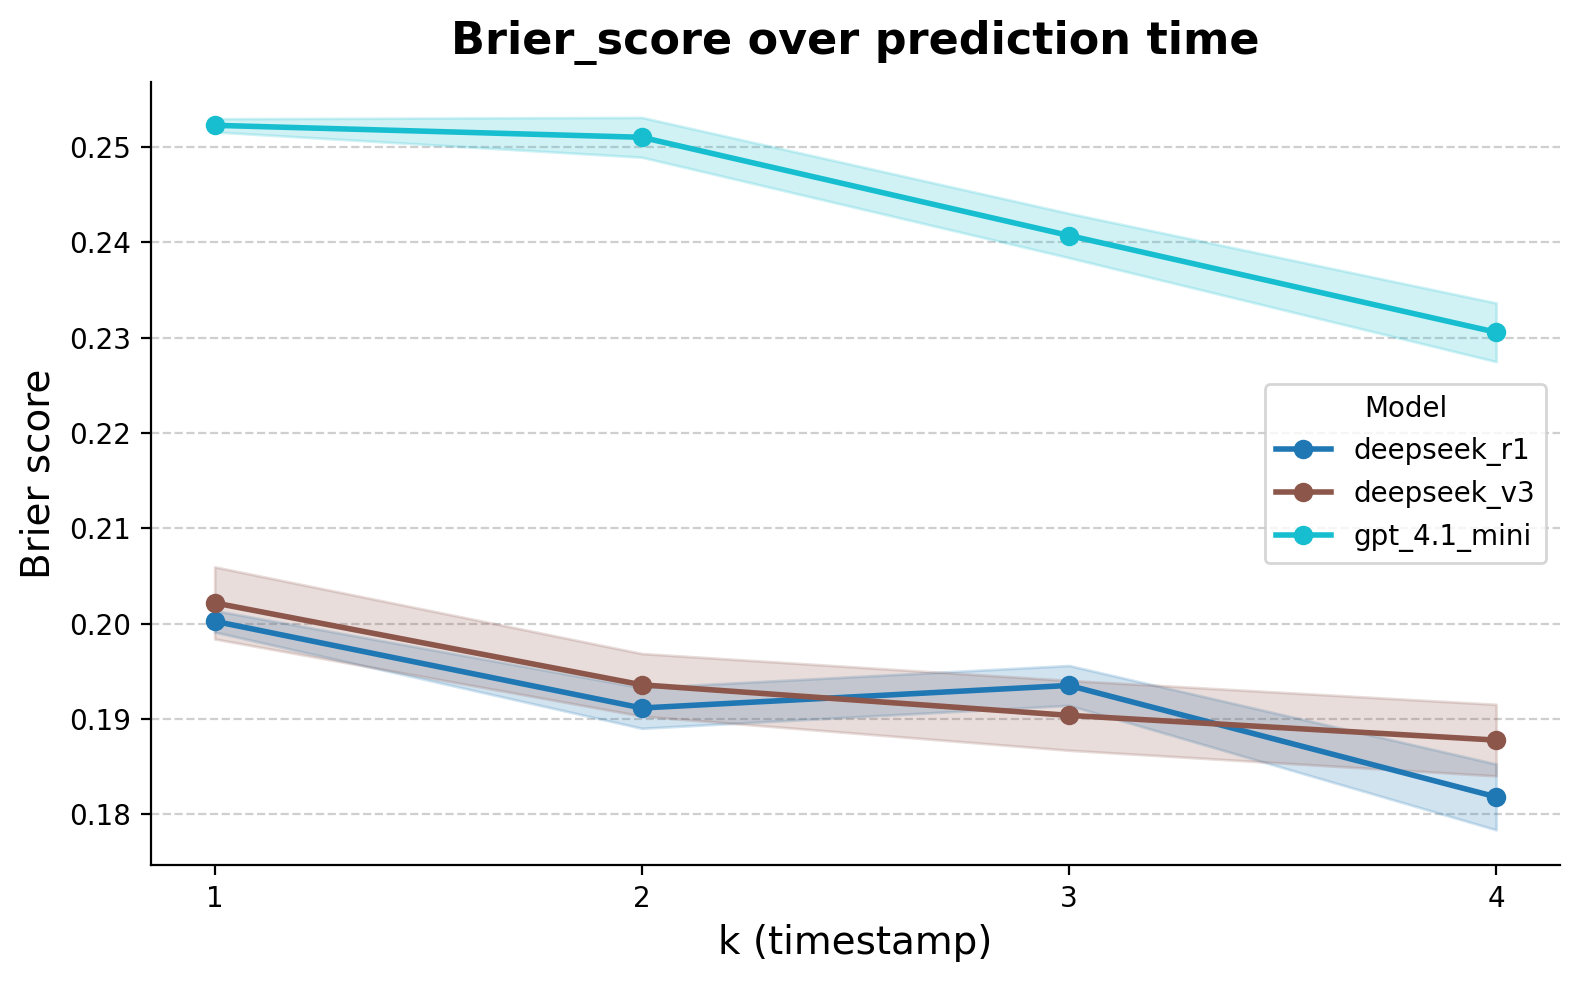

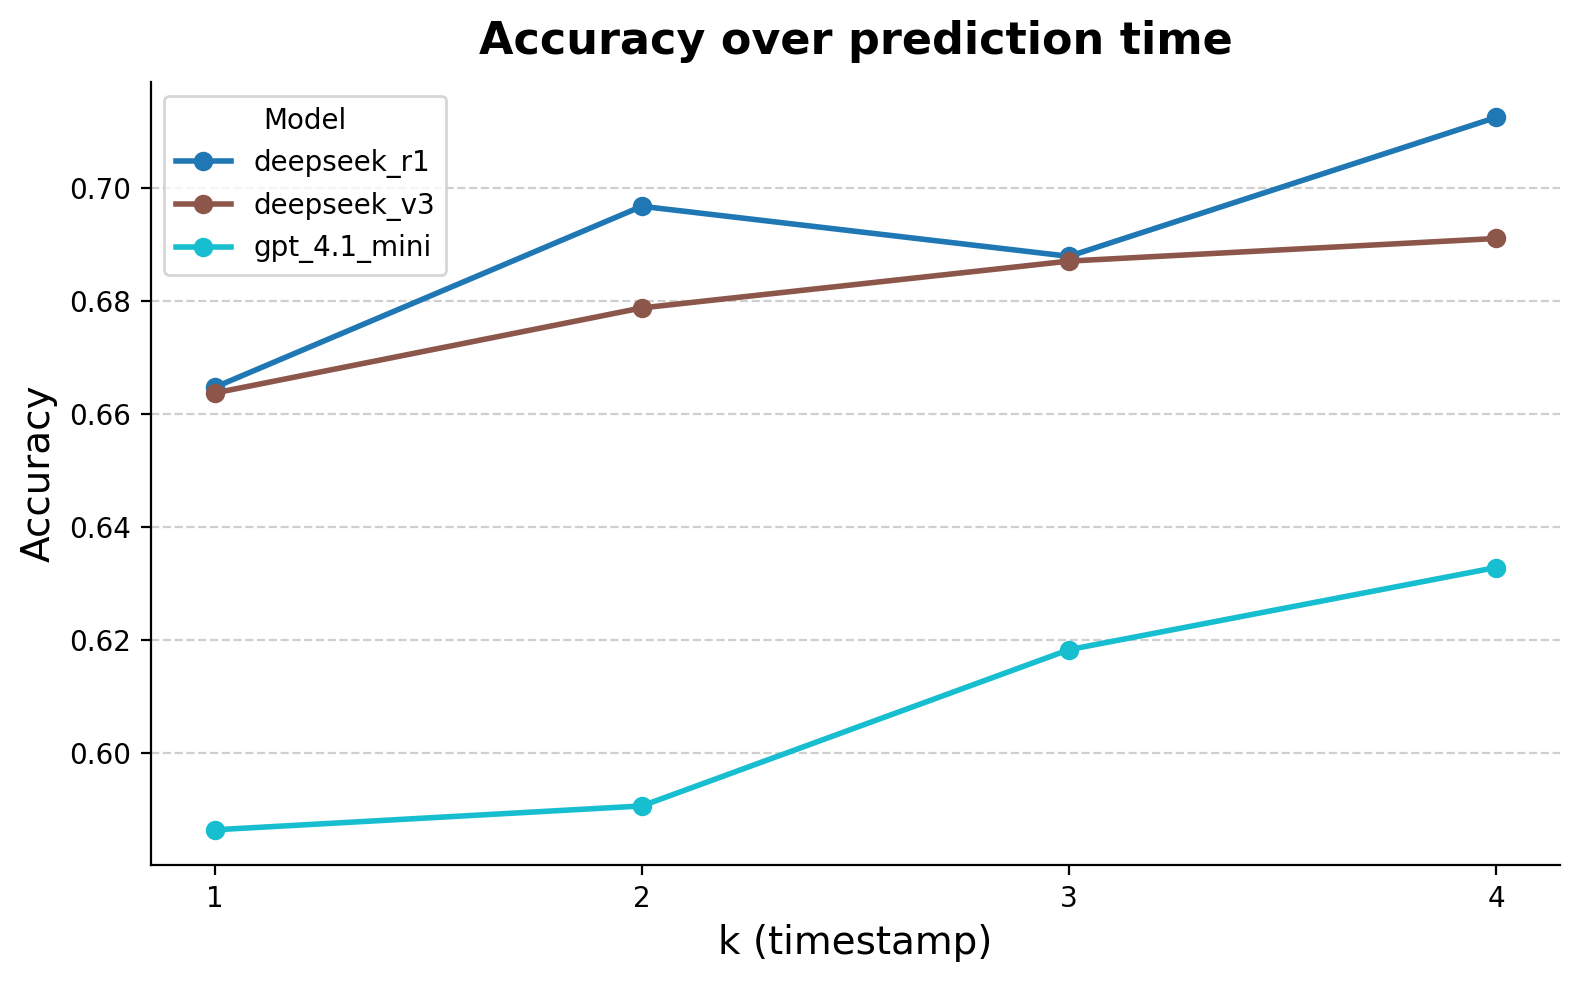

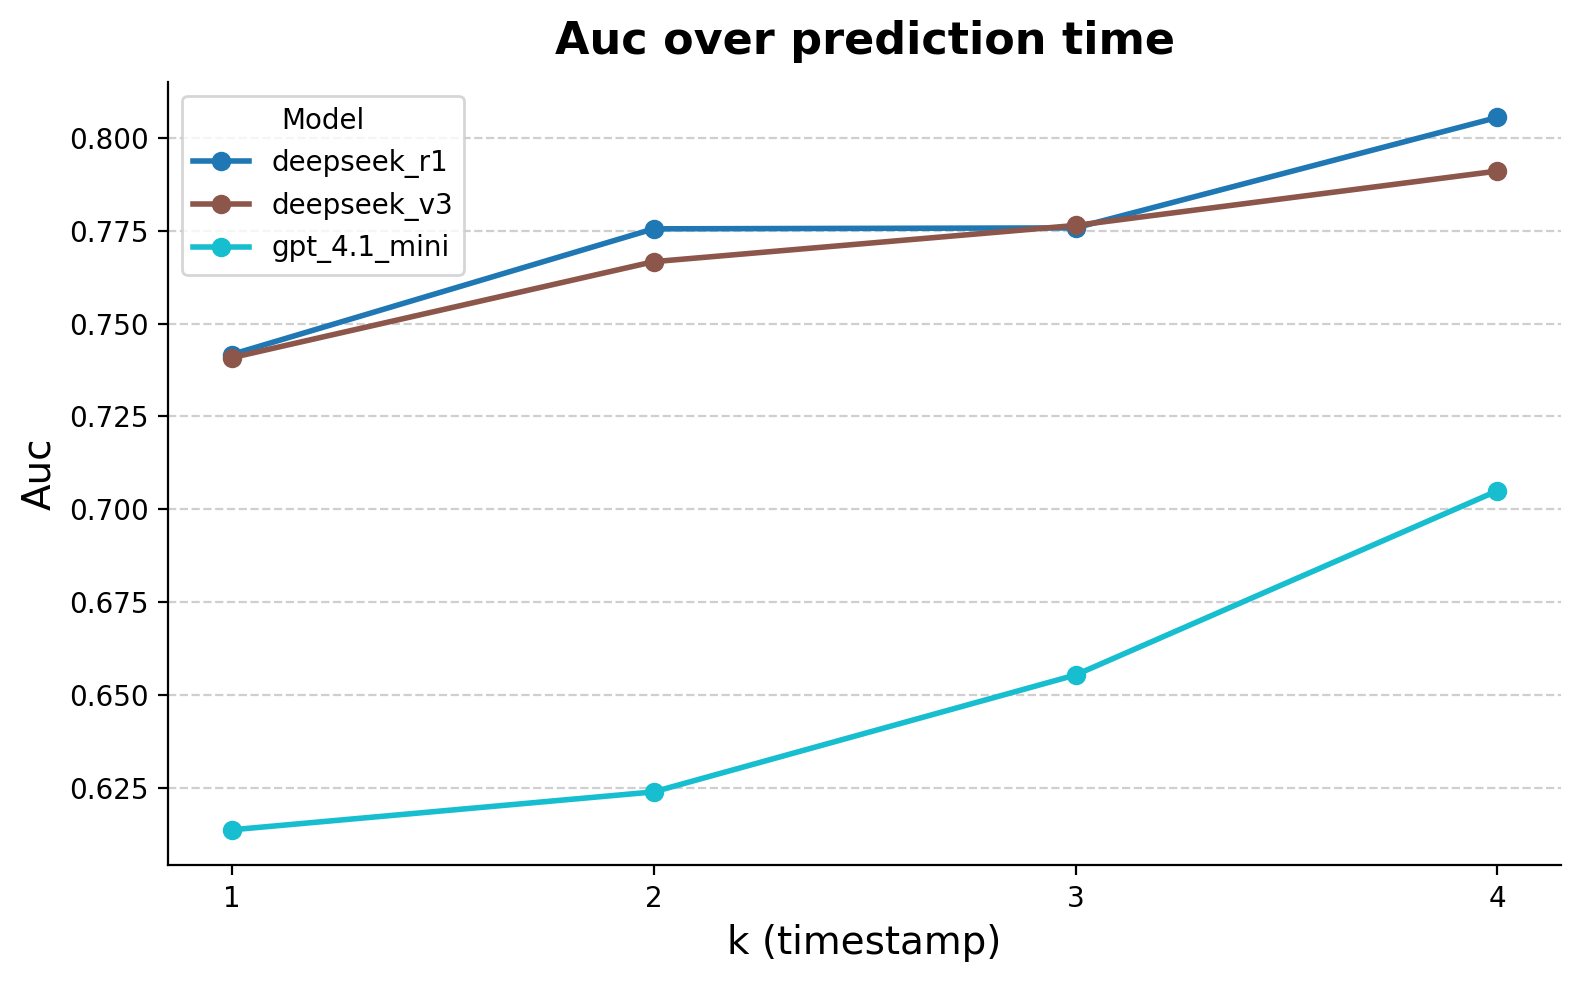

In [294]:
plot_metrics_over_time(df, ['deepseek_r1','deepseek_v3', "gpt_4.1_mini"])

We can clearly see here that the metrics improve as the resolution date of the event approaches, meaning that the incoming data boosts model accuracy in prediction.

## Calibration effect on single models

Let's see how individual models are affected by the calibration. The metrics we are interested in are Brier Score and accuracy, since AUC-ROC is not affected by monotonous scaling.

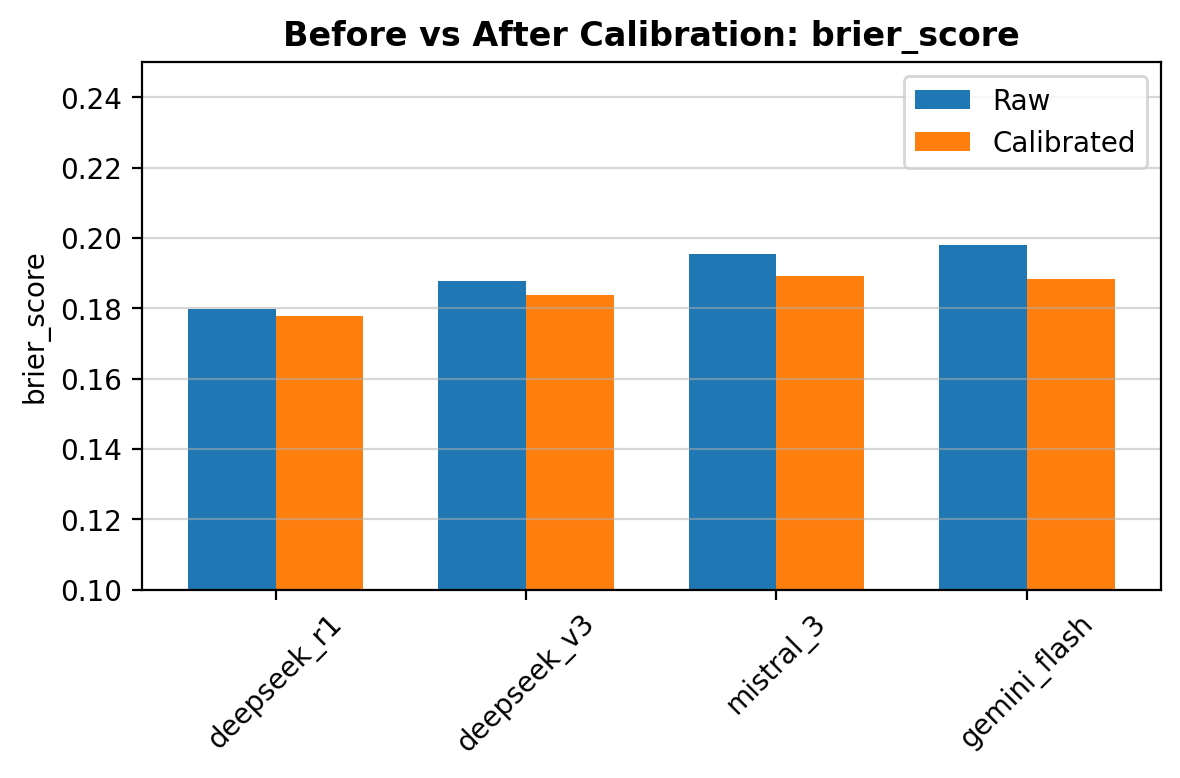

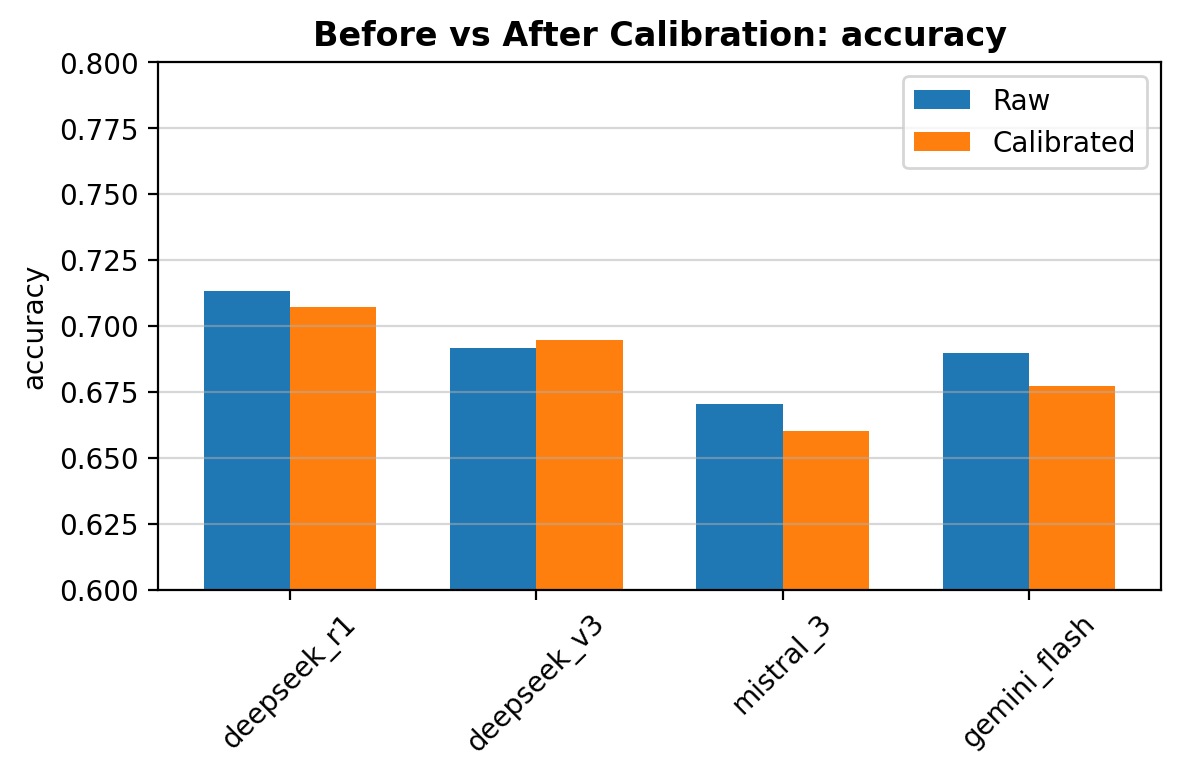

In [301]:
models_calibration_results = plot_before_after_calibration_bar(df, ['deepseek_r1','deepseek_v3','mistral_3','gemini_flash'], n_seeds=100)

In [271]:
models_calibration_results

,raw_brier_score,raw_accuracy,cal_brier_score,cal_accuracy
model,,,,
deepseek_r1,0.179723,0.713178,0.177793,0.707289
deepseek_v3,0.187751,0.691800,0.183787,0.694711
mistral_3,0.195553,0.670289,0.189167,0.660089
gemini_flash,0.198169,0.689911,0.188383,0.677200


These calibration by metric results suggest that calibration helps improve the brier scores, but does not consisently boost the accuracy of the models, actually decreasing the initial accuracy in some cases. The best achieved brier score on individual calibration is 0.178 on calibrated DeepSeek R1, demeaned by 100 random seeds.

## Exploring aggregation methods

### How does aggregation affect individual models?

Let's have a look at how DeepSeekR1 metrics are affected by aggregation across prediction dates (k=1,2,3,4).

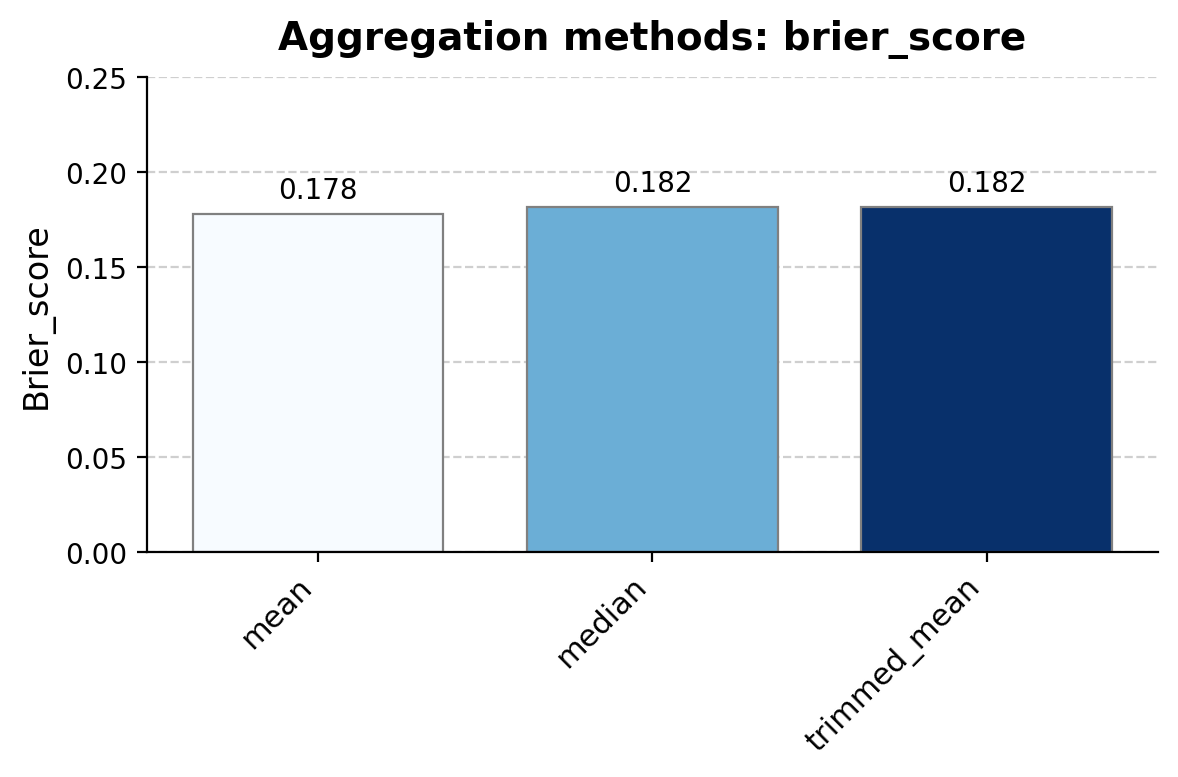

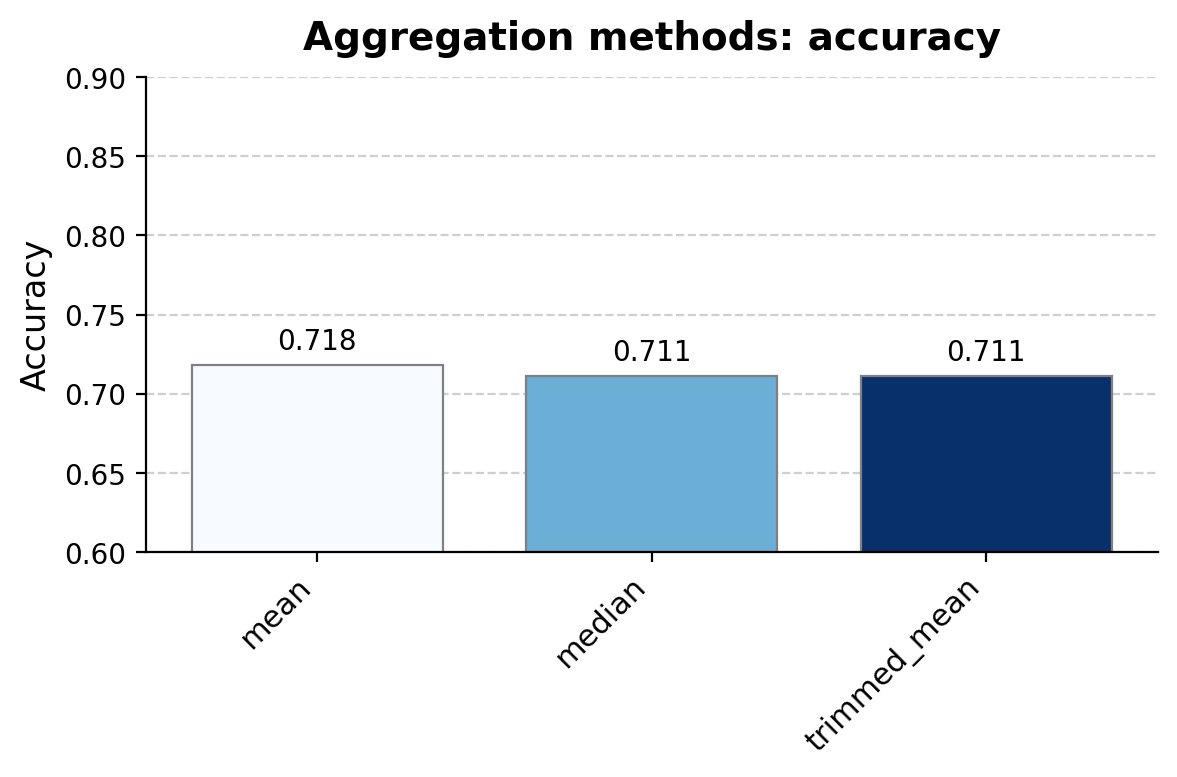

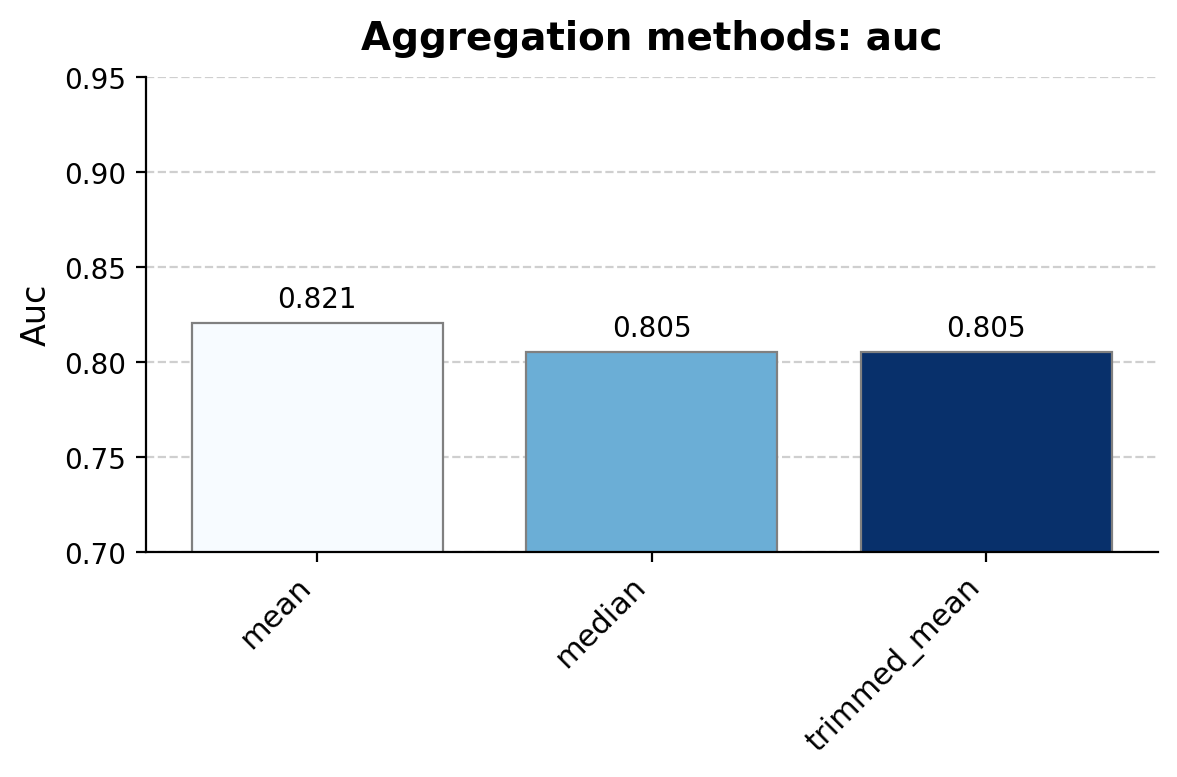

In [278]:
deepseek_r1_res = plot_aggregation_metrics(df, setups=[
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},
])

In [279]:
deepseek_r1_res

{'mean': {'brier_score': 0.17813691073219662,
  'accuracy': 0.7181544633901705,
  'auc': 0.8206016896764887},
 'median': {'brier_score': 0.18174232698094284,
  'accuracy': 0.7111334002006018,
  'auc': 0.8054378734803214},
 'trimmed_mean': {'brier_score': 0.18174232698094284,
  'accuracy': 0.7111334002006018,
  'auc': 0.8054378734803214}}

Averaging across time yields 0.178 brier score, which is a little better than the single results at the last timestamp. The developing view can benefit from earlier predictions, which can sometimes rely more on historic prospective. However, the effect is not very large compared to taking the last prediction at k=4.

### How do predictions improve if we aggregate the best models' probabilities?

Let's see whether aggregating the strongest models with the weaker ones (but still good ones) yields better results. We will once again try three aggregation methods: mean, median, trimmed mean. The selected setups for aggregation include the best models predictions at different prediction dates.

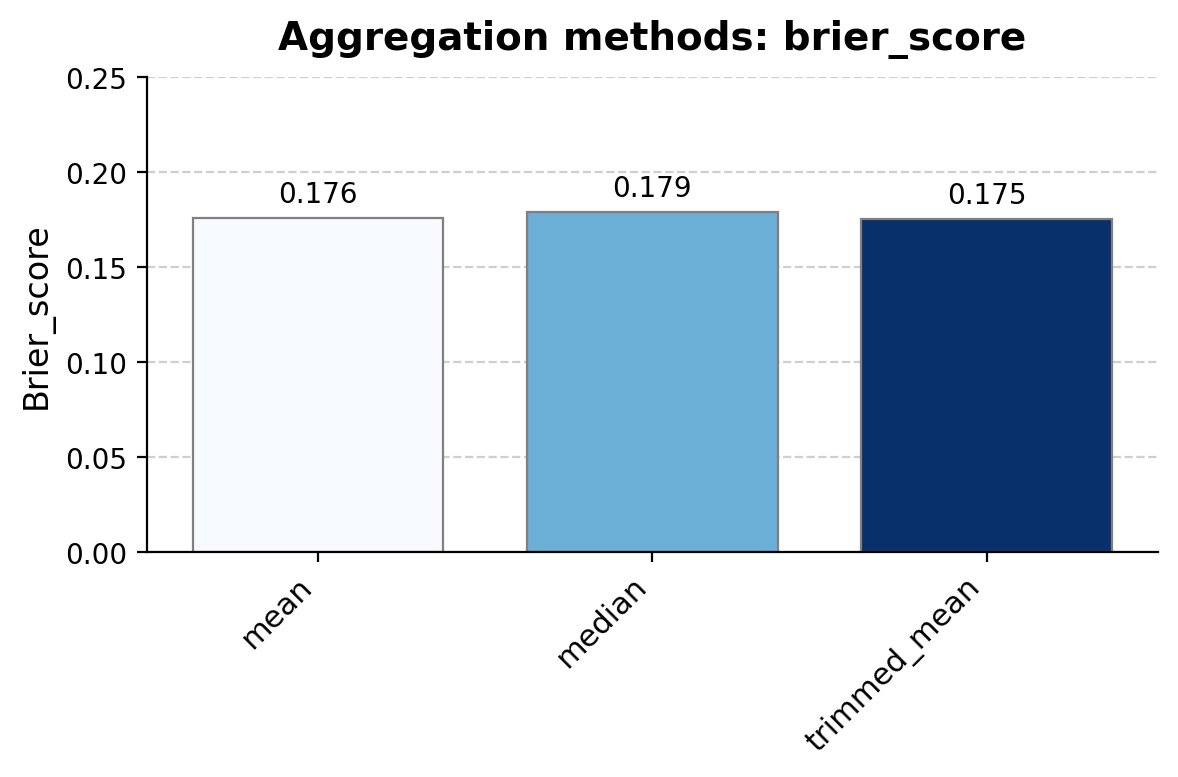

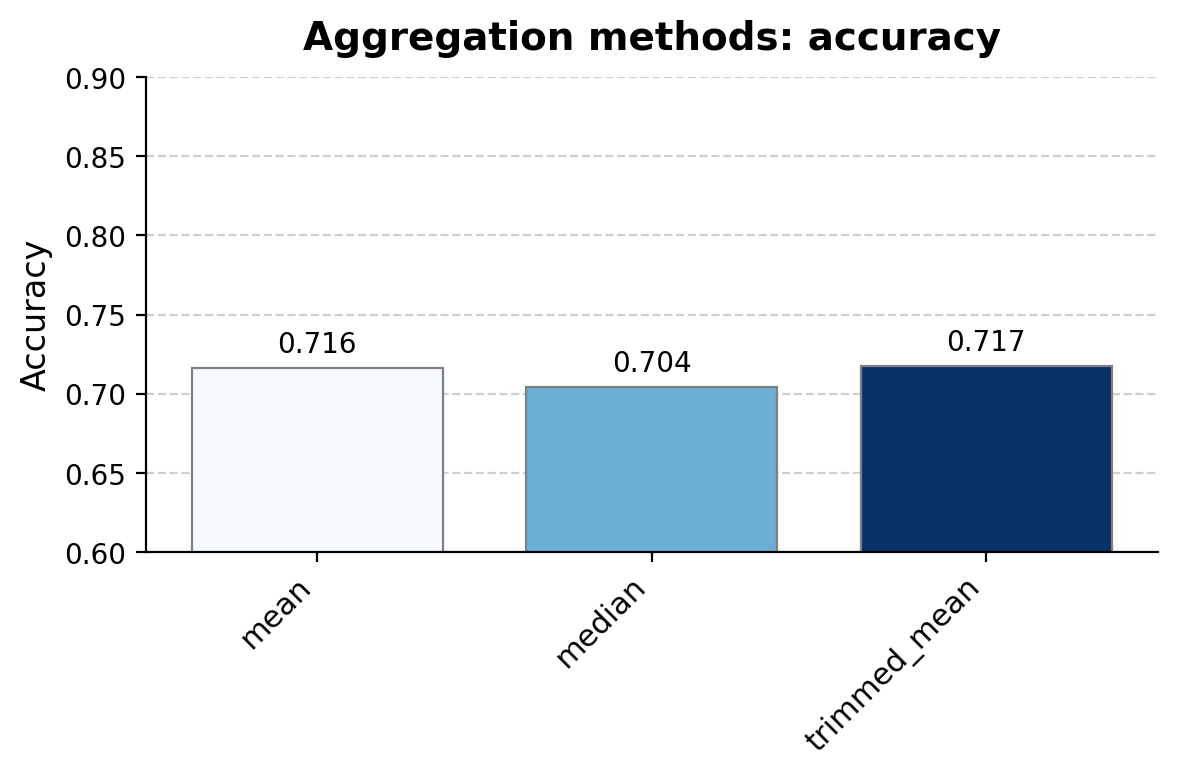

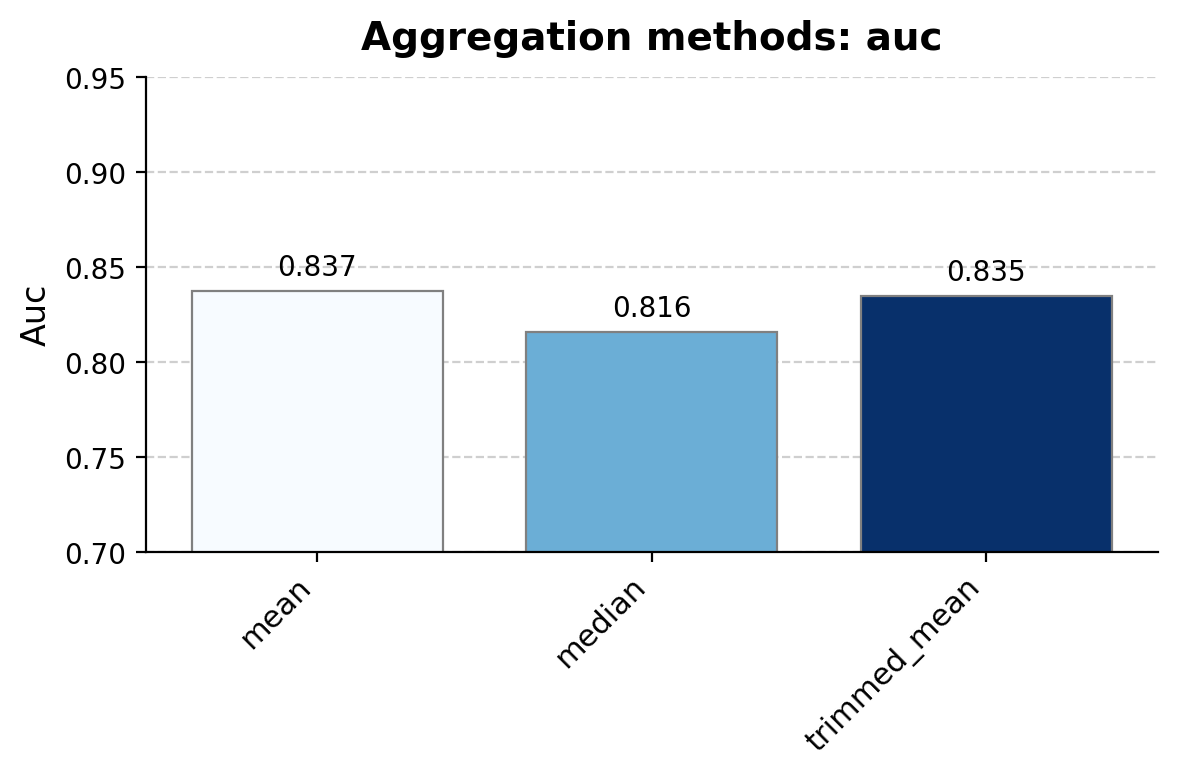

In [280]:
aggregations_res = plot_aggregation_metrics(df, setups=[
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},

    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':4},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':3},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':2},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':1},

    {'model':'mistral_3','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'gemini_flash','prompt_type':'basic_prompt','n_articles':10,'k':4}
    ])

In [260]:
aggregations_res

{'mean': {'brier_score': 0.1760104500504541,
  'accuracy': 0.7164480322906155,
  'auc': 0.8372963287077552},
 'median': {'brier_score': 0.1790229061553986,
  'accuracy': 0.7043390514631686,
  'auc': 0.8160040838438137},
 'trimmed_mean': {'brier_score': 0.1752973243567104,
  'accuracy': 0.7174571140262361,
  'auc': 0.8350522982039423}}

The best aggregation technique for the best setups is using the trimmed mean - demeaning the. The brier score it achieves is the lowest with 0.175 and an accuracy of 0.71. But can it be improved further by calibration?

### **Inside view VS Outside view (Base rates)** (IMPORTANT)

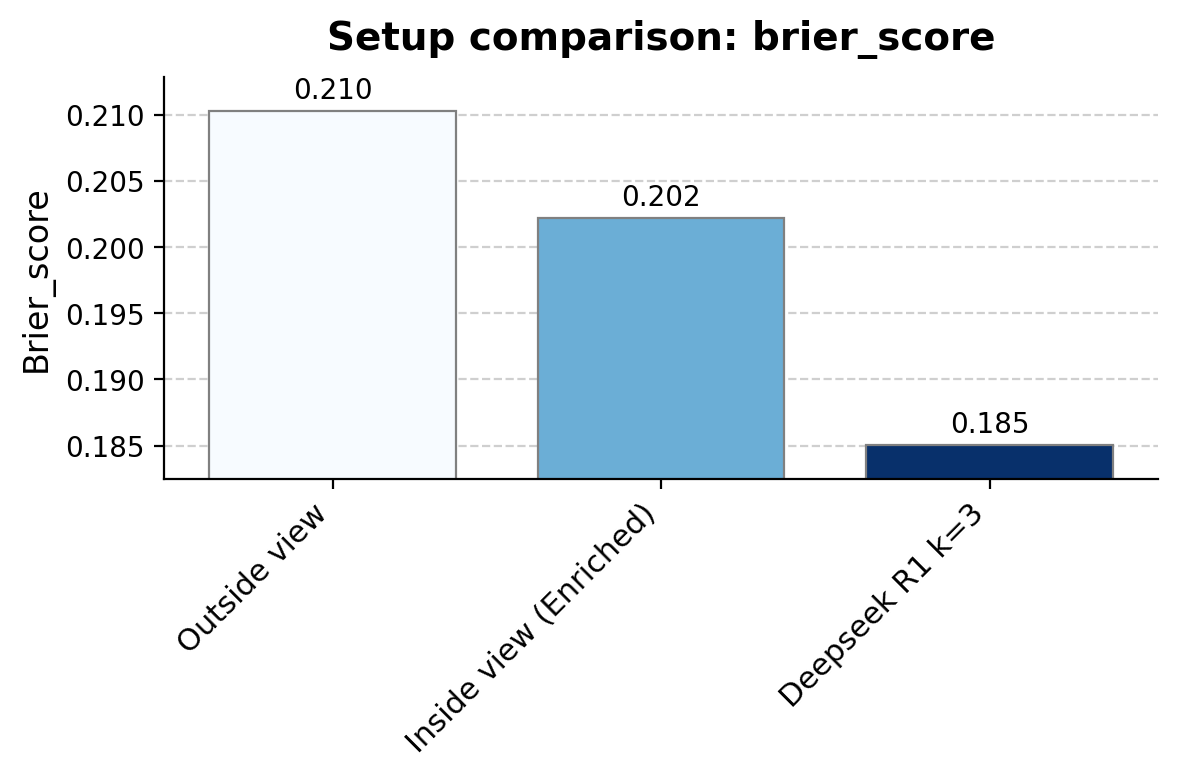

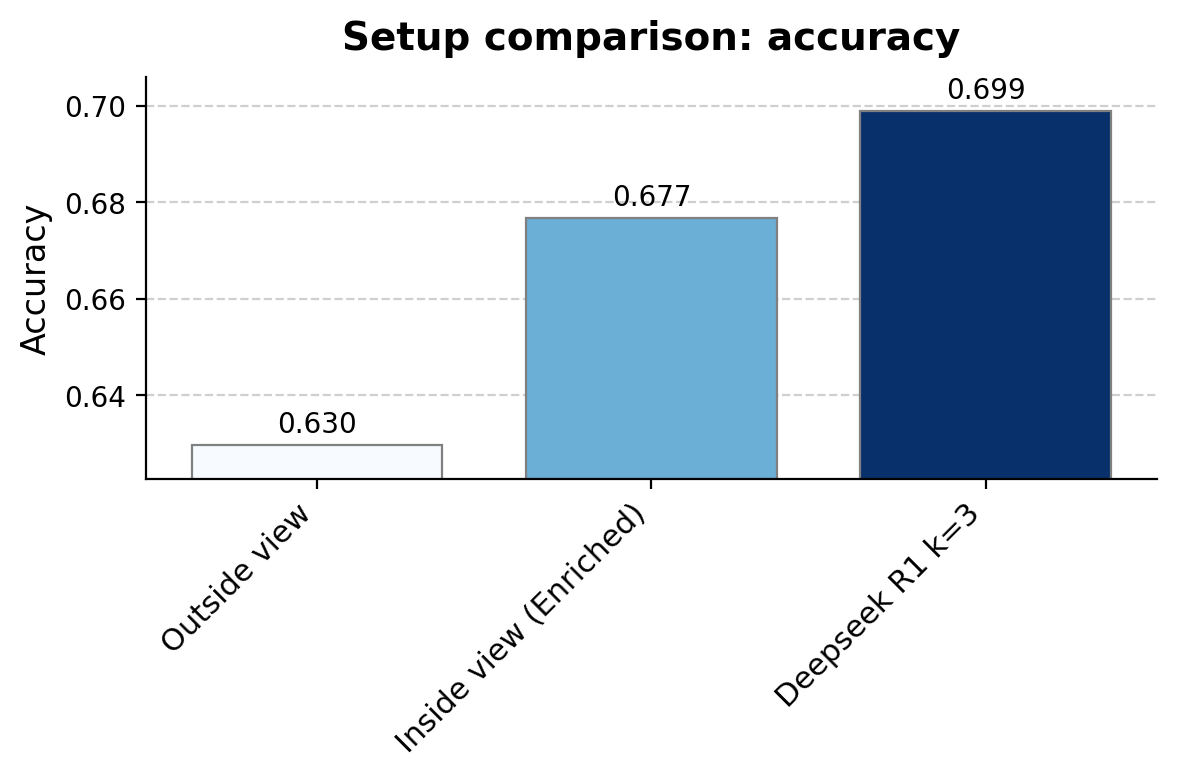

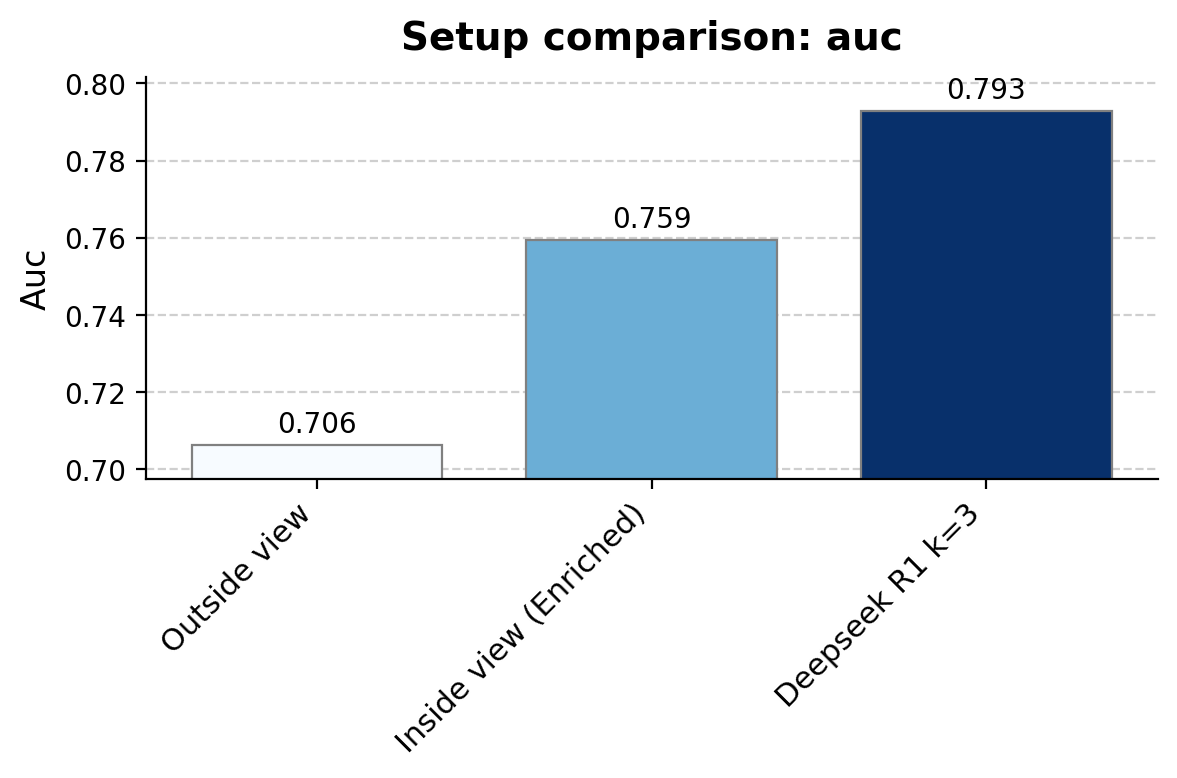

In [289]:
inside_outside_results = plot_setup_comparison_bar(df, {
    'Outside view': {'model':None,'prompt_type':None,'n_articles':None,'k':None,'use':'base_rate'},
    'Inside view (Enriched)': {'model':'deepseek_r1','prompt_type':'two_stages','n_articles':10,'k':3},
    'Deepseek R1 k=3': {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
},)

In [290]:
inside_outside_results

{'Outside view': {'brier_score': 0.2102953953953954,
  'accuracy': 0.6296296296296297,
  'auc': 0.7062175761754662},
 'Inside view (Enriched)': {'brier_score': 0.20218398398398402,
  'accuracy': 0.6766766766766766,
  'auc': 0.7593495534541632},
 'Deepseek R1 k=3': {'brier_score': 0.18501170000000003,
  'accuracy': 0.699,
  'auc': 0.7929127180205761}}

So we see that no results are better than the classic pipeline on the strongest model. Opposite to expectations, the base rates so not improve predictions, since Polymarket offers mostly unique questions not seen before, with very few base classes.

## **Calibrating the aggregate predictions** (IMPORTANT)

In [ ]:
def evaluate_aggregated_calibration(
    df: pd.DataFrame,
    setups: list[dict],
    methods: list[str] = ['mean', 'median', 'trimmed_mean'],
    n_seeds: int = 10,
    test_size: float = 0.5,
    calibration: str = 'logistic'
) -> pd.DataFrame:
    subsets = [
        df[(df['model']==s['model']) &
           (df['prompt_type']==s['prompt_type']) &
           (df['n_articles']==s['n_articles']) &
           (df['k']==s['k'])].sort_values('event_id')
        for s in setups
    ]
    common = set.intersection(*(set(sub['event_id']) for sub in subsets))
    arr = np.vstack([
        sub[sub['event_id'].isin(common)]['probability_yes'].values
        for sub in subsets
    ])
    y_true_all = subsets[0][subsets[0]['event_id'].isin(common)]['true_label'].values

    funcs = {
        'mean':           lambda x: np.mean(x, axis=0),
        'median':         lambda x: np.median(x, axis=0),
        'trimmed_mean':   lambda x: np.mean(np.sort(x, axis=0)[1:-1], axis=0) 
                                  if x.shape[0] > 2 else np.mean(x, axis=0),
    }

    records = []
    for m in methods:
        if m not in funcs:
            continue
        raw_metrics = {'brier_score': [], 'accuracy': [], 'auc': []}
        cal_metrics = {'brier_score': [], 'accuracy': [], 'auc': []}

        preds_all = funcs[m](arr)
        for seed in range(n_seeds):
            idx = np.arange(len(y_true_all))
            train_idx, test_idx = train_test_split(idx, test_size=test_size, random_state=seed)

            y_train, y_test = y_true_all[train_idx], y_true_all[test_idx]
            p_train, p_test = preds_all[train_idx], preds_all[test_idx]

            rm = compute_metrics(y_test, p_test)
            for k, v in rm.items():
                raw_metrics[k].append(v)

            if calibration == 'logistic':
                model = LogisticRegression()
                model.fit(p_train.reshape(-1,1), y_train)
                p_test_cal = model.predict_proba(p_test.reshape(-1,1))[:,1]
            else:
                ir = IsotonicRegression(out_of_bounds='clip')
                ir.fit(p_train, y_train)
                p_test_cal = ir.transform(p_test)

            cm = compute_metrics(y_test, p_test_cal)
            for k, v in cm.items():
                cal_metrics[k].append(v)

        # averaging by seeds just for robustness
        avg_raw = {f'raw_{k}': np.mean(v) for k, v in raw_metrics.items()}
        avg_cal = {f'cal_{k}': np.mean(v) for k, v in cal_metrics.items()}
        records.append({'method': m, **avg_raw, **avg_cal})

    df_res = pd.DataFrame(records)
    return df_res

In [274]:
evaluate_aggregated_calibration(df, setups=[
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':3},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':2},
    {'model':'deepseek_r1','prompt_type':'basic_prompt','n_articles':10,'k':1},

    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':4},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':3},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':2},
    {'model':'deepseek_v3','prompt_type':'champs_know','n_articles':15,'k':1},

    {'model':'mistral_3','prompt_type':'basic_prompt','n_articles':10,'k':4},
    {'model':'gemini_flash','prompt_type':'basic_prompt','n_articles':10,'k':4}
    ], test_size=0.5, n_seeds=100)

,method,raw_brier_score,raw_accuracy,raw_auc,cal_brier_score,cal_accuracy,cal_auc
0,mean,0.175426,0.718145,0.839670,0.165625,0.751956,0.839669
1,median,0.178103,0.706310,0.819029,0.174048,0.728911,0.819032
2,trimmed_mean,0.174677,0.719153,0.837529,0.166040,0.744738,0.837553


The table above is translated into a chart manually below

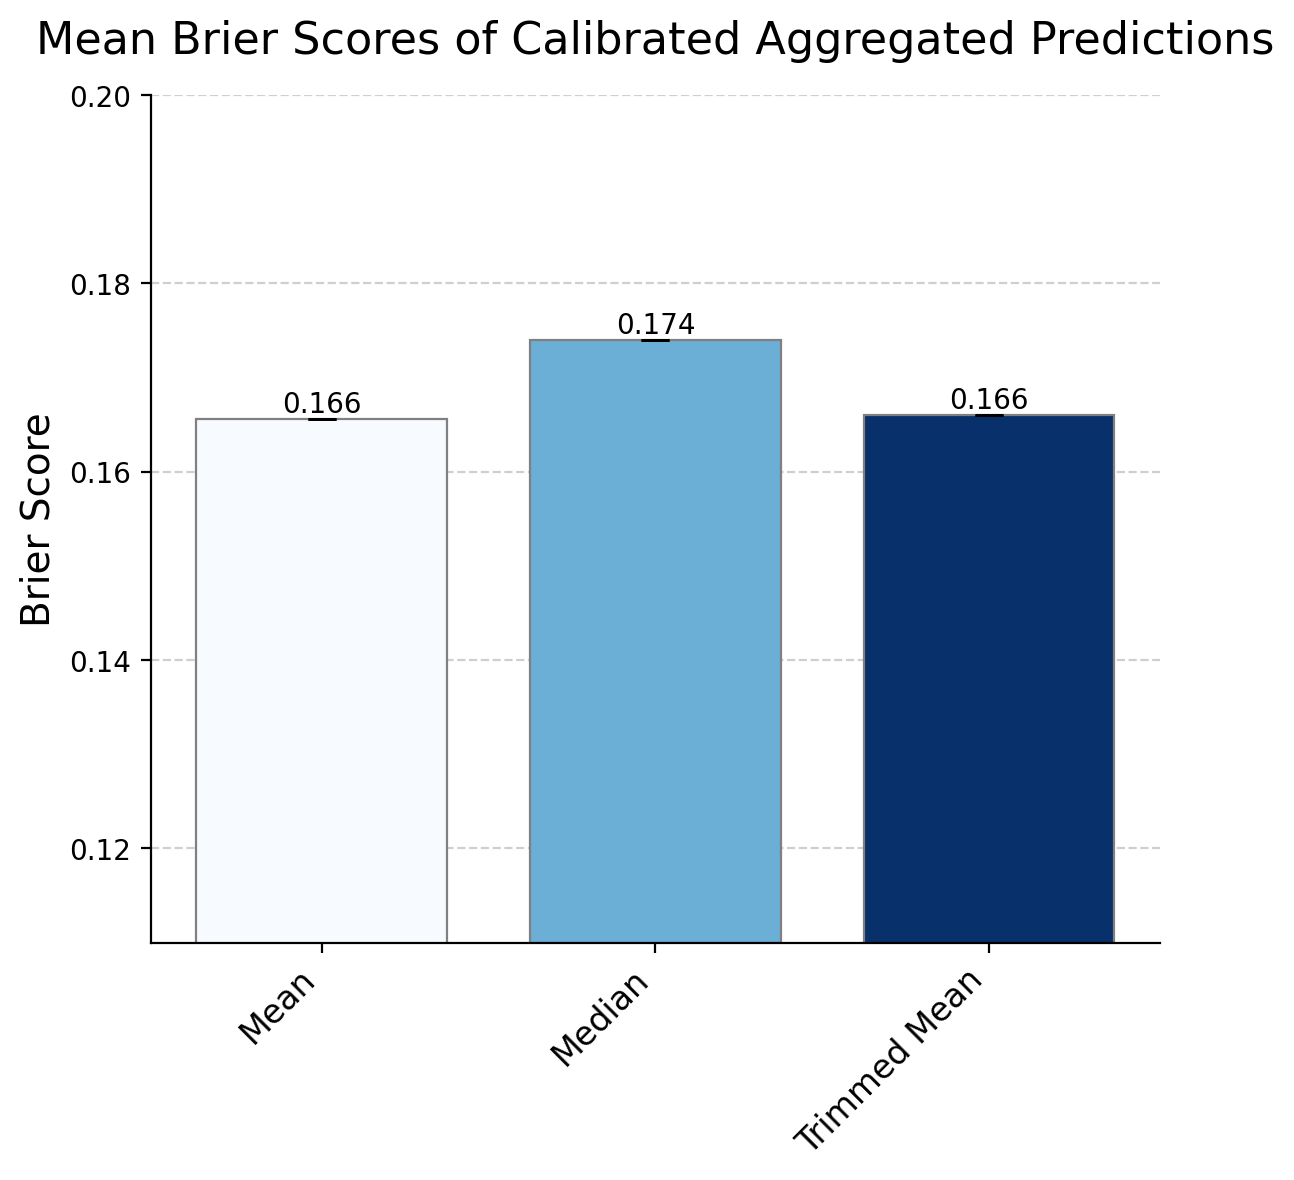

In [299]:
plot_bar_with_error(
    labels=["Mean", "Median", "Trimmed Mean"],
    means=[0.165625, 0.174048, 0.166040],
    sems=[0, 0, 0],
    title="Mean Brier Scores of Calibrated Aggregated Predictions",
    ylabel="Brier Score",
    ylim=(0.11, 0.20)
)

We see a shocking 0.165 brier score with calibrated demeaning aggregation! And an accuracy of 75%!

### Conclusions from metrics

The best pipeline is to aggregate the best models' predictions with a simple mean or with a trimmed mean and then calibrate these predictions to achieve a stunning Brier score of **0.165**. The accuracy achieved by this approach is 0.75, which is pretty high for the given level of uncertainty in question from polymarket.

The best model is by far the DeepSeek R1 model, followed by DeepSeekV3. Then come Mistral-3 and Gemini Flash.

The best way of aggregation is a trimmed mean across different models, which yields a brier score of 0.175. However, simple demeaning does not fall too far behind.

Results concerning the base rates: base rates show worse metrics (all three: brier, accuracy, auc-roc) than the enhanced inside view, supported by the base rate. However, the enriched predictions are worse than the standard ones, meaning that the base rates only confuse the model and it should be prompted with news only.

The results also suggest that individually calibrating the best model does not improve quality by much, but calibrating the aggregated predictions of several agents improves the final result not only in terms of the forecast confidence, but also its accuracy. This may come from the fact that some models specialize better in some categories of questions where others might lack expertise.

# Calibration curves

## Calibration curves

Let's have a look at how well our models are naturally calibrated and how their calibration can be improved

In [ ]:
def plot_calibration_curve(y_true, y_pred, label, n_bins=5):
    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    true_fraction = [
        np.mean(y_true[(y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])] == 1)
        for i in range(n_bins)
    ]
    plt.plot(bin_centers, true_fraction, marker='.', label=label, markersize=10, linewidth=2)
    


def plot_multiple_setups(df, setups, n_bins=5):
    plt.figure(figsize=(8, 6))
    for setup in setups:
        subset = df[
            (df['model'] == setup['model']) &
            (df['prompt_type'] == setup['prompt']) &
            (df['n_articles'] == setup['n_articles']) &
            (df['k'] == setup['k'])
        ]
        plot_calibration_curve(subset['true_label'], subset['probability_yes'], 
                               f"{setup['model']} | k={setup['k']}", n_bins)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
    plt.title("Calibration Curves Comparison", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.show()



def plot_time_evolution(df, model_name, prompt_type, n_articles, n_bins=10):
    plt.figure(figsize=(8, 7))
    for k in sorted(df['k'].unique()):
        subset = df[(df['model'] == model_name) & (df['prompt_type'] == prompt_type) & (df['k'] == k) & (df['n_articles'] == n_articles)]
        plot_calibration_curve(subset['true_label'], subset['probability_yes'], f"k={k}", n_bins)
    plt.plot([0, 1], [0, 1], 'k--', label='Perfect', linewidth=1.5)
    plt.title(f"Calibration Over Time for {model_name}", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Mean Actual Outcome")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid(alpha=0.5, linestyle='--')
    plt.show()



def plot_before_after_calibration(df, setup, method='logistic', n_bins=10, test_size=0.3, random_state=None):
    subset = df[
        (df['model'] == setup['model']) &
        (df['prompt_type'] == setup['prompt']) &
        (df['n_articles'] == setup['n_articles']) &
        (df['k'] == setup['k'])
    ]
    y_true = subset['true_label'].values
    y_pred = subset['probability_yes'].values.reshape(-1, 1)

    X_train, X_test, y_train, y_test = train_test_split(
        y_pred, y_true,
        test_size=test_size,
        random_state=random_state
    )

    plot_calibration_curve(y_test, X_test.ravel(), 'Raw', n_bins)

    if method == 'logistic':
        calibrator = LogisticRegression()
        calibrator.fit(X_train, y_train)
        y_calibrated = calibrator.predict_proba(X_test)[:, 1]
    else:
        calibrator = IsotonicRegression(out_of_bounds='clip')
        calibrator.fit(X_train.ravel(), y_train)
        y_calibrated = calibrator.transform(X_test.ravel())

    plot_calibration_curve(y_test, y_calibrated, f'Calibrated', n_bins)

    plt.plot([0, 1], [0, 1], 'k--', label='Perfect')
    plt.title(f"Before vs After Calibration ({method})", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.legend()
    plt.ylim([-0.05, 1.05])
    plt.grid(0.5, linestyle='--')
    plt.show()

Let's have a look at how calibration curves progress over time with the growth of prediction date $k\ \in (1, 2, 3, 4)$ :
$$\text{pred date}_k= \text{start date} + (\text{end date} - \text{start date} - 1) \cdot k/4$$

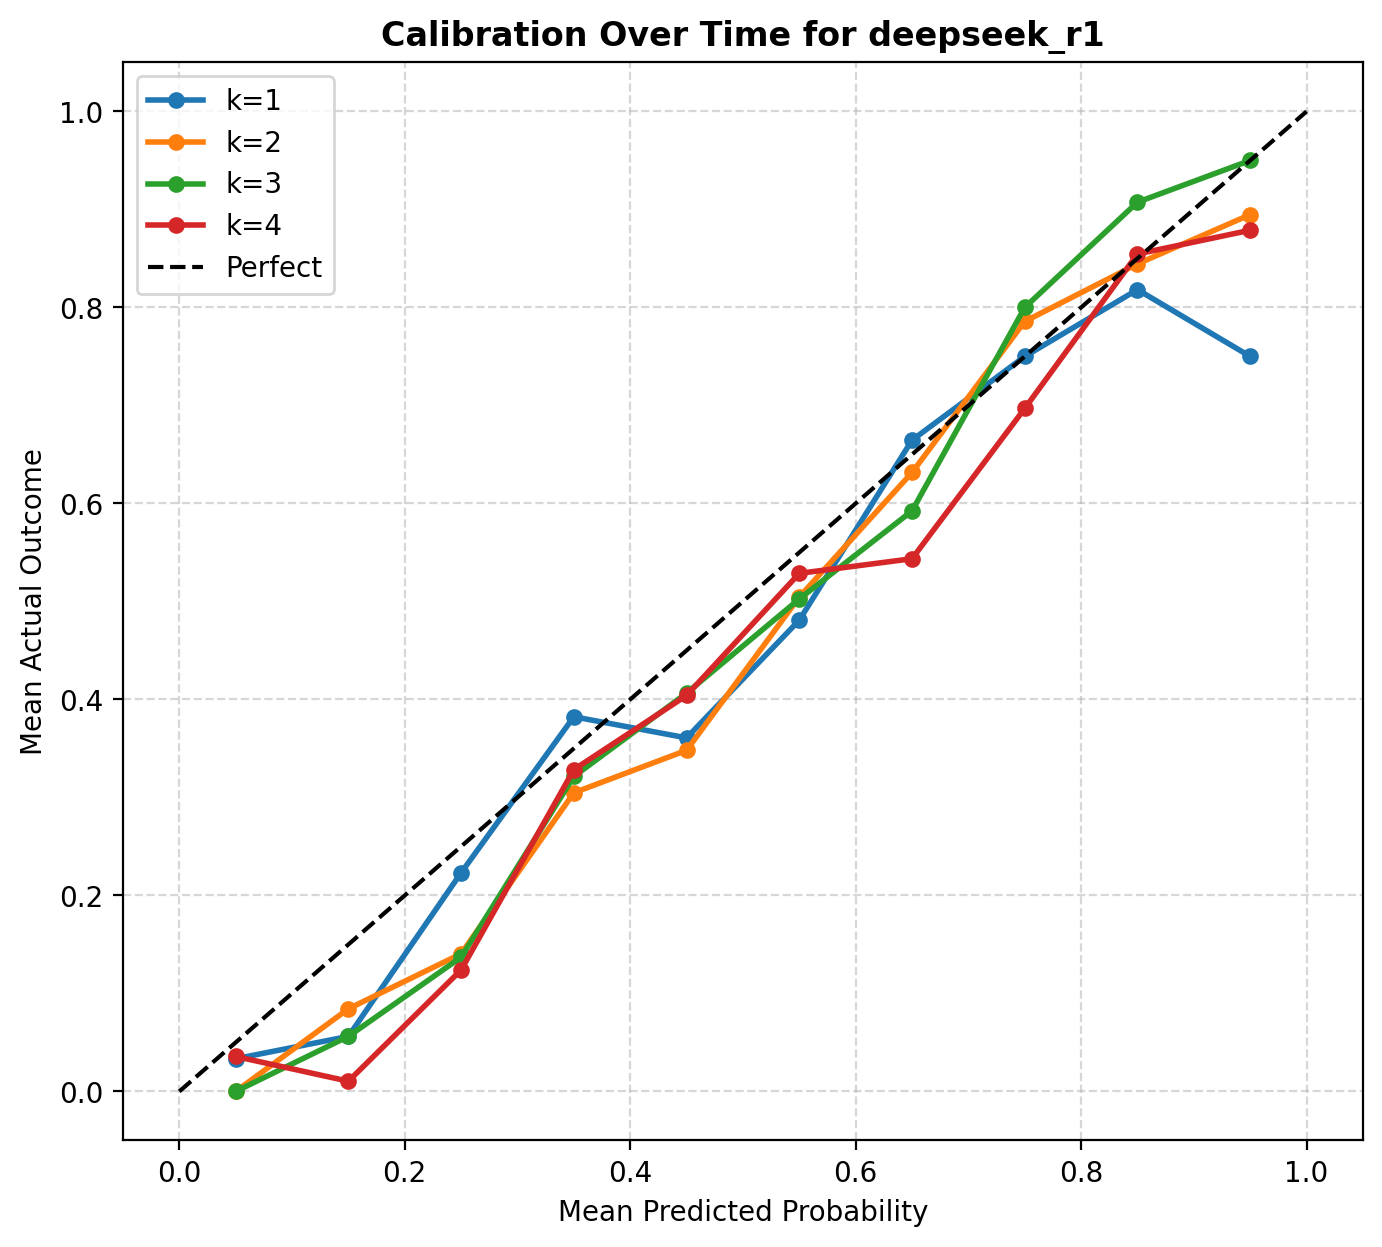

In [91]:
plot_time_evolution(df, "deepseek_r1", "basic_prompt", 10, 10)

We can see that DeepSeek R1 is naturally pretty well calibrated and is more or less stable through time.

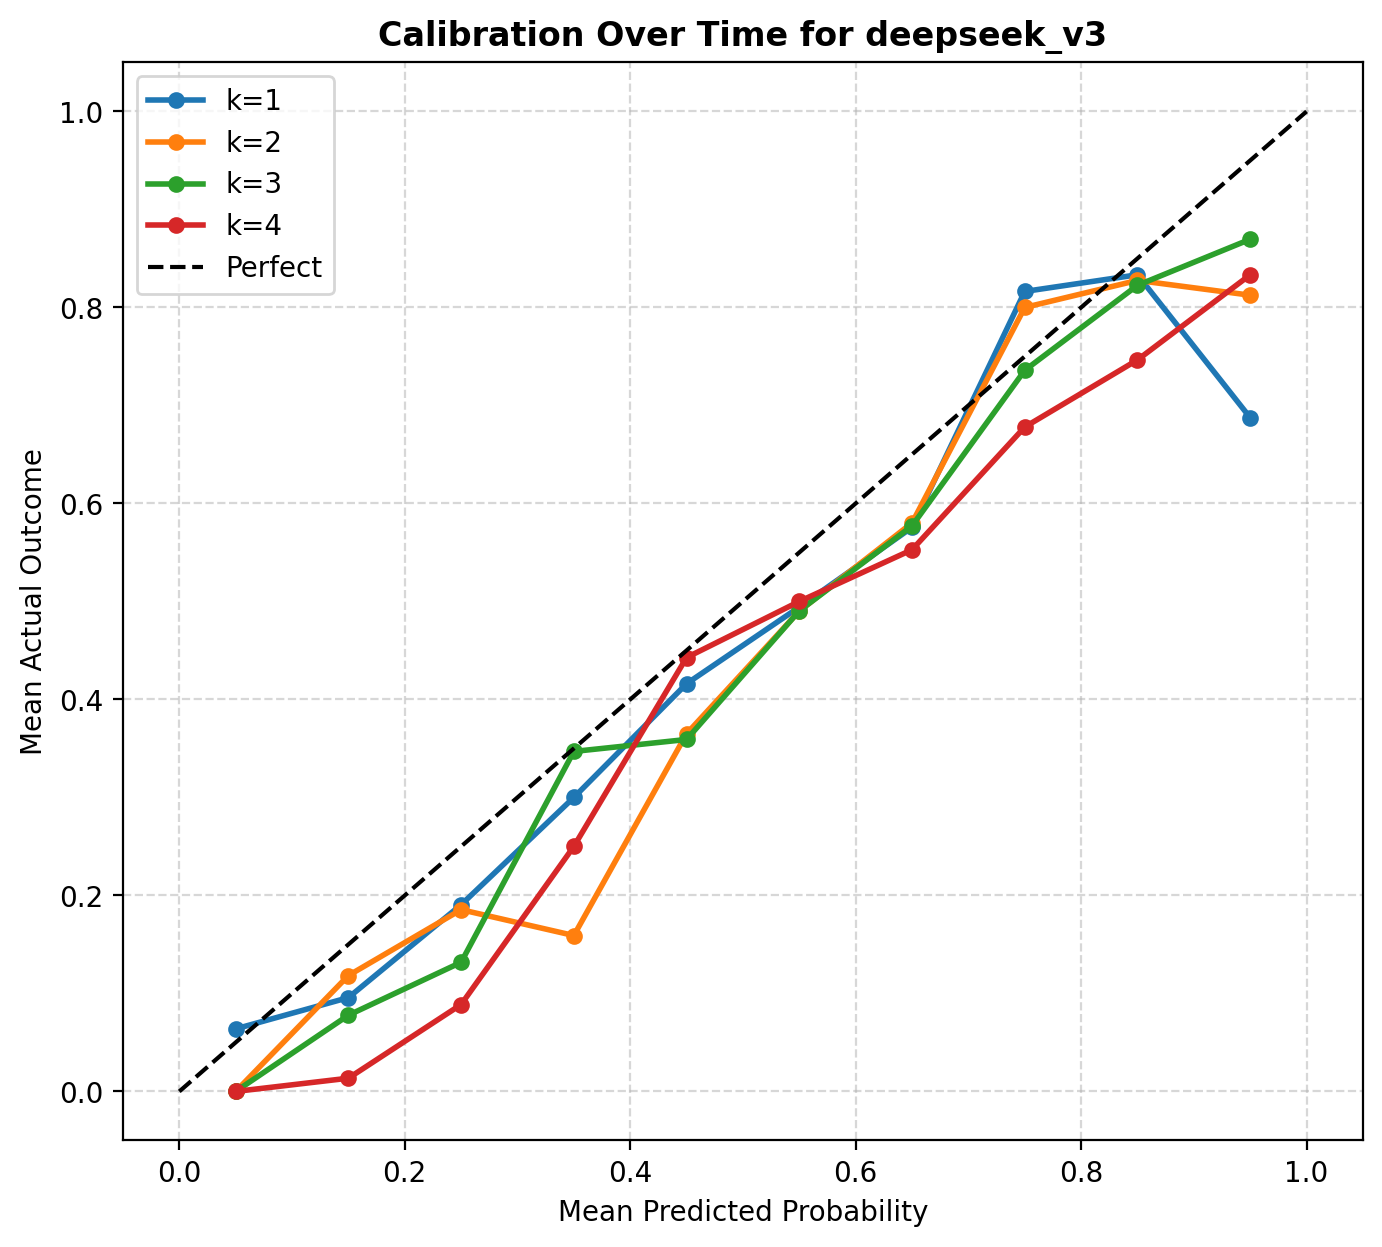

In [92]:
plot_time_evolution(df, "deepseek_v3", "champs_know", 15, n_bins=10)

We can see that DeepSeek R1 is naturally better calibrated than DeepSeek V3, which are the two top models in our setup. Deepseek V3 tends to be overconfident when stating the probabilities for events with 90-100% confidence

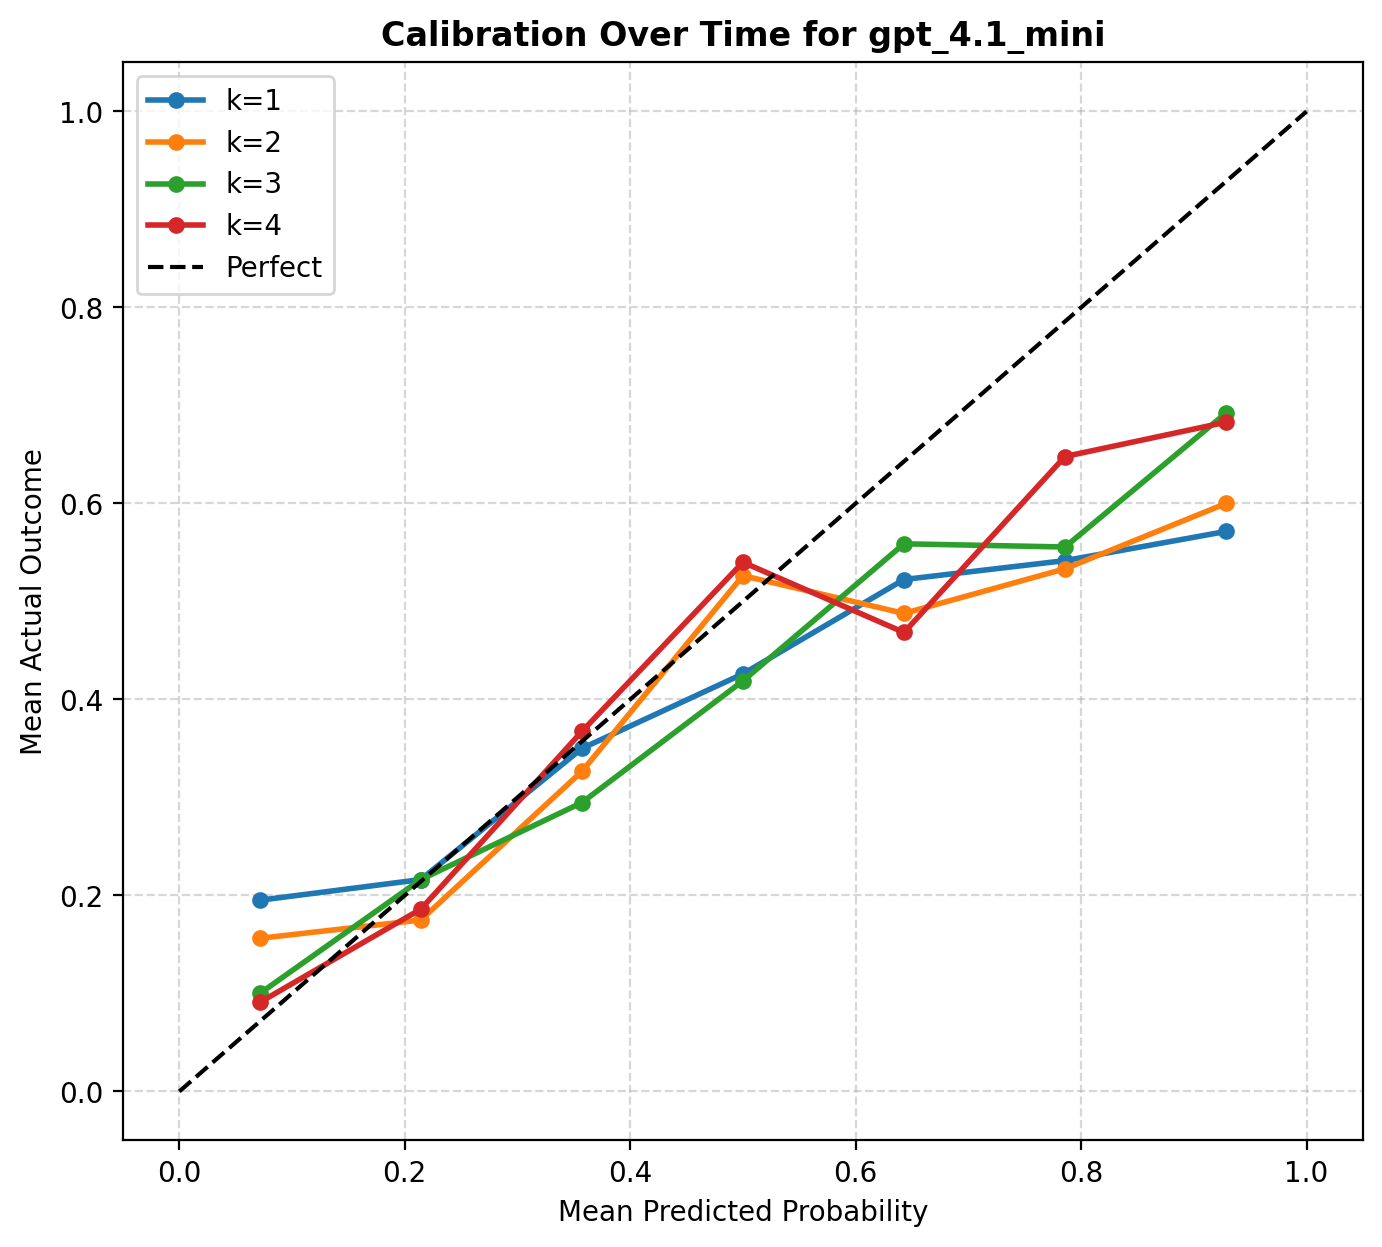

In [93]:
plot_time_evolution(df, "gpt_4.1_mini", "basic_prompt", 15, n_bins=7)

GPT 4.1 mini is an example of a model which is not well calibrated. This is seen on the calibration plot by the fact that its very often overly confident that the event will take place.

## Inside view VS Outside view

One interesting thing to look at is whether the stronger models can provide well calibrated forecasts without knowing the context and news data. This is called the "outside view" and it is contrary to the "inside view", in which case the model makes a forecast that is based on news context. 

In my experimental setup, I ask the model (DeepSeek R1, by far the strongest one) to give an outside view for the event and then enrich the inside data with the base rate.

It is interesting to see whether the base rates observed from the model are well calibrated at all or the model gives them on random.

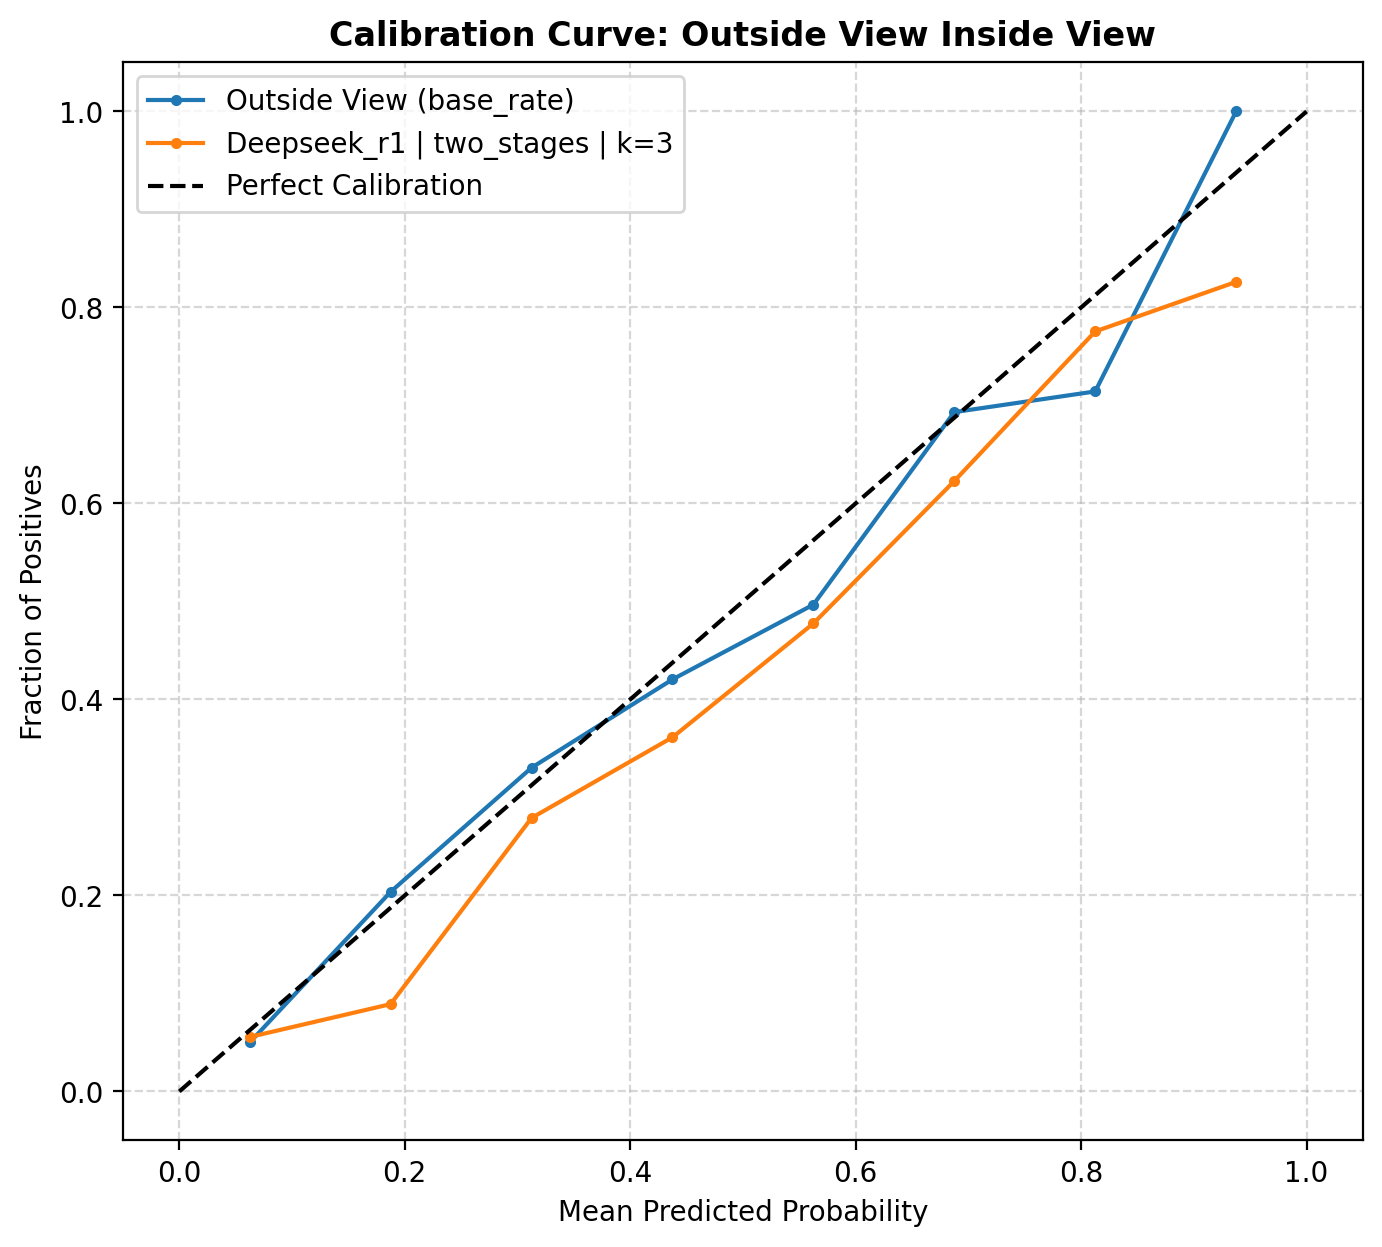

In [162]:
mask = (
    (df['model'] == 'deepseek_r1') &
    (df['prompt_type'] == 'two_stages') &
    (df['n_articles'] == 10) &
    (df['k'] == 3)
)
subset = df[mask]

y_true  = subset['true_label'].values
y_out   = subset['base_rate'].values
y_model = subset['probability_yes'].values


n_bins = 8
bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

def calc_fraction(y_true, y_pred):
    fractions = []
    for i in range(n_bins):
        sel = (y_pred >= bin_edges[i]) & (y_pred < bin_edges[i+1])
        if sel.sum() > 0:
            fractions.append(y_true[sel].mean())
        else:
            fractions.append(np.nan)
    return fractions

frac_out   = calc_fraction(y_true, y_out)
frac_model = calc_fraction(y_true, y_model)

plt.figure(figsize=(8,7))
plt.plot(bin_centers, frac_out,   marker='.', label='Outside View (base_rate)')
plt.plot(bin_centers, frac_model, marker='.', label='Deepseek_r1 | two_stages | k=3')
plt.plot([0, 1], [0, 1], 'k--',     label='Perfect Calibration')
plt.title('Calibration Curve: Outside View Inside View', weight='bold')
plt.xlabel('Mean Predicted Probability')
plt.ylabel('Fraction of Positives')
plt.ylim(-0.05, 1.05)
plt.grid(alpha=0.5, linestyle='--')
plt.legend()
plt.show()

Suprisingly, the model shows that its base rates are naturally well calibrated and in fact a little better than their enriched version.

## Calibrated VS Uncalibrated models examples
Now let's Have a look at how the models calibration can improve them on some examples:

DeepSeek R1

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


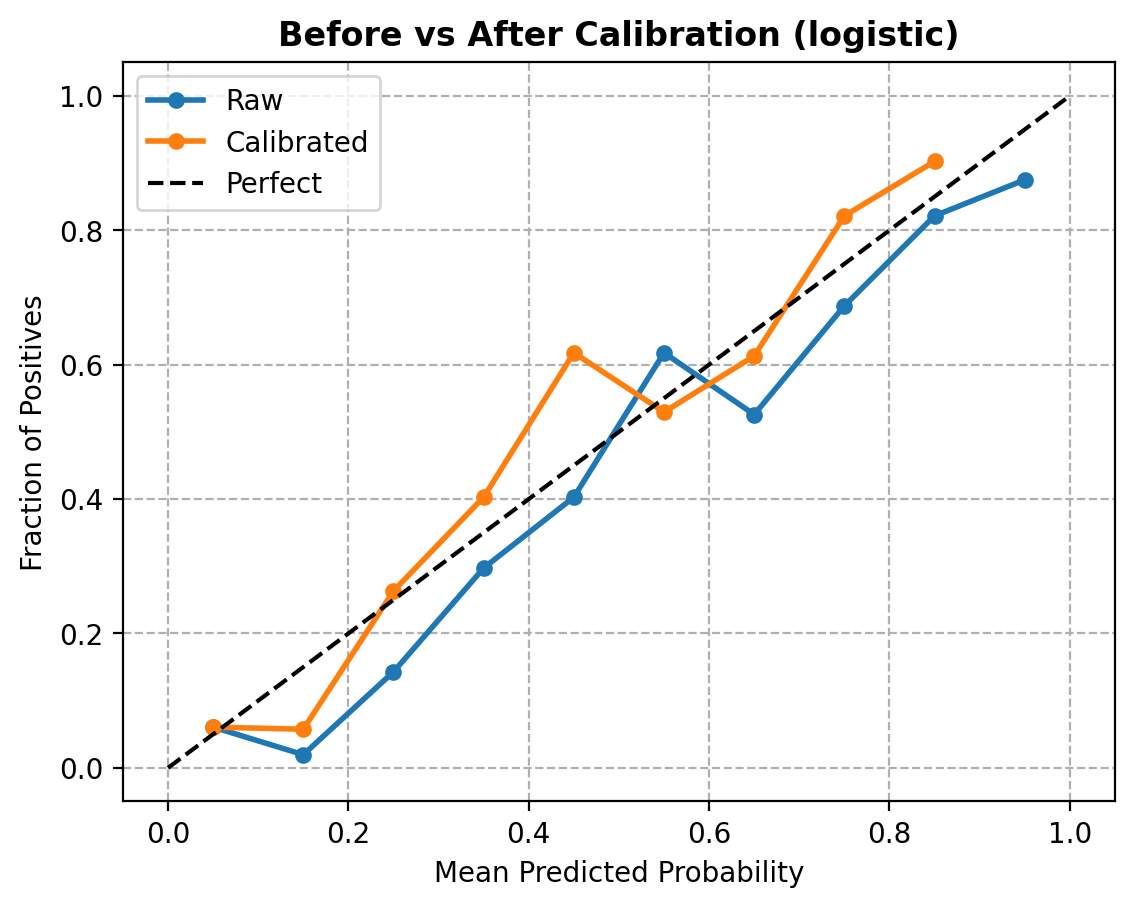

In [145]:
plot_before_after_calibration(df, setup={
    'model': 'deepseek_r1',
    'prompt': 'basic_prompt',
    'n_articles': 10,
    'k': 4
}, method='logistic', n_bins=10, test_size=0.5, random_state=42)

Due to the fact that the model is naturally calibrated on its own, calibration almost does not affect it. The plots do not look as smooth because the data has been split into the equal parts for this setup.

DeepSeek V3

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


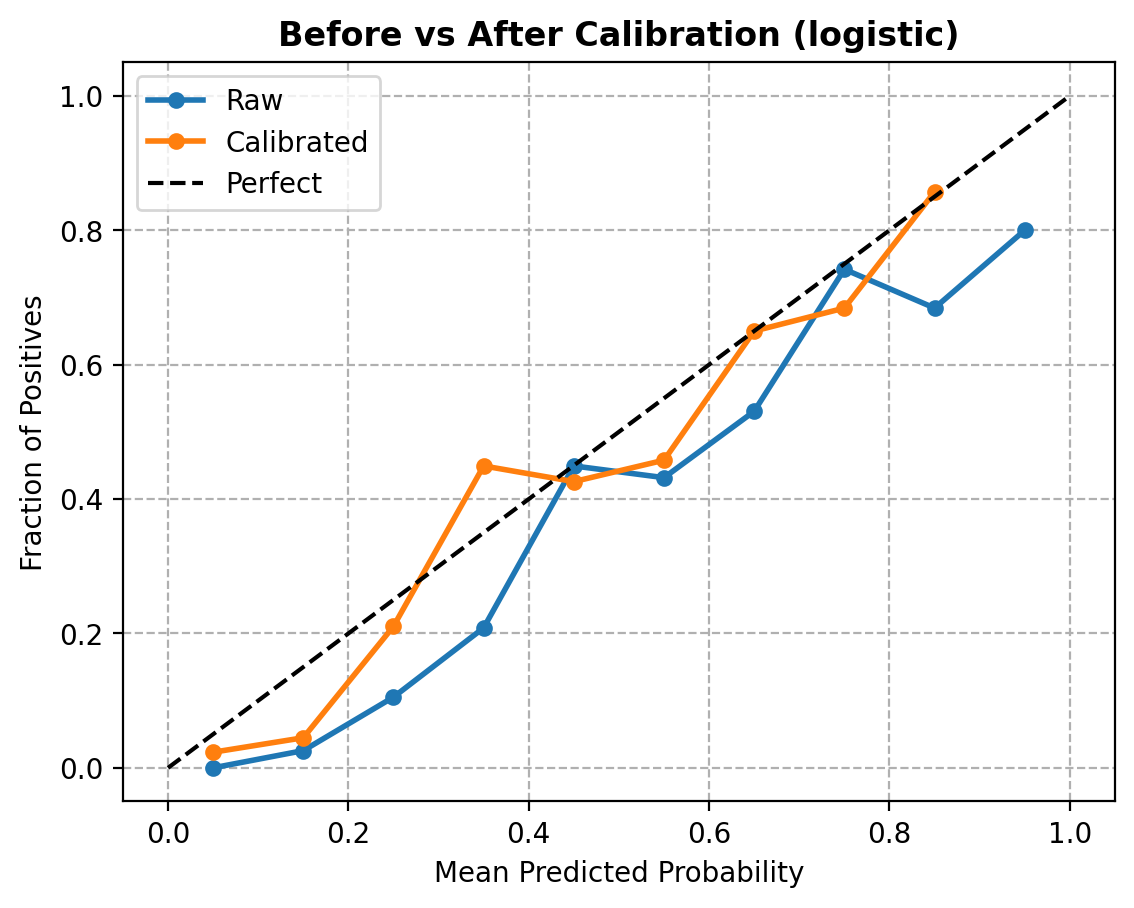

In [146]:
plot_before_after_calibration(df, setup={
    'model': 'deepseek_v3',
    'prompt': 'champs_know',
    'n_articles': 15,
    'k': 4
}, method='logistic', n_bins=10, test_size=0.5, random_state=42)

We can see that no matter the train-test split on our data, the calibration brings the models predictions a bit lower, meaning that the model by itself tennds to be overconfident

Mistral 3

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


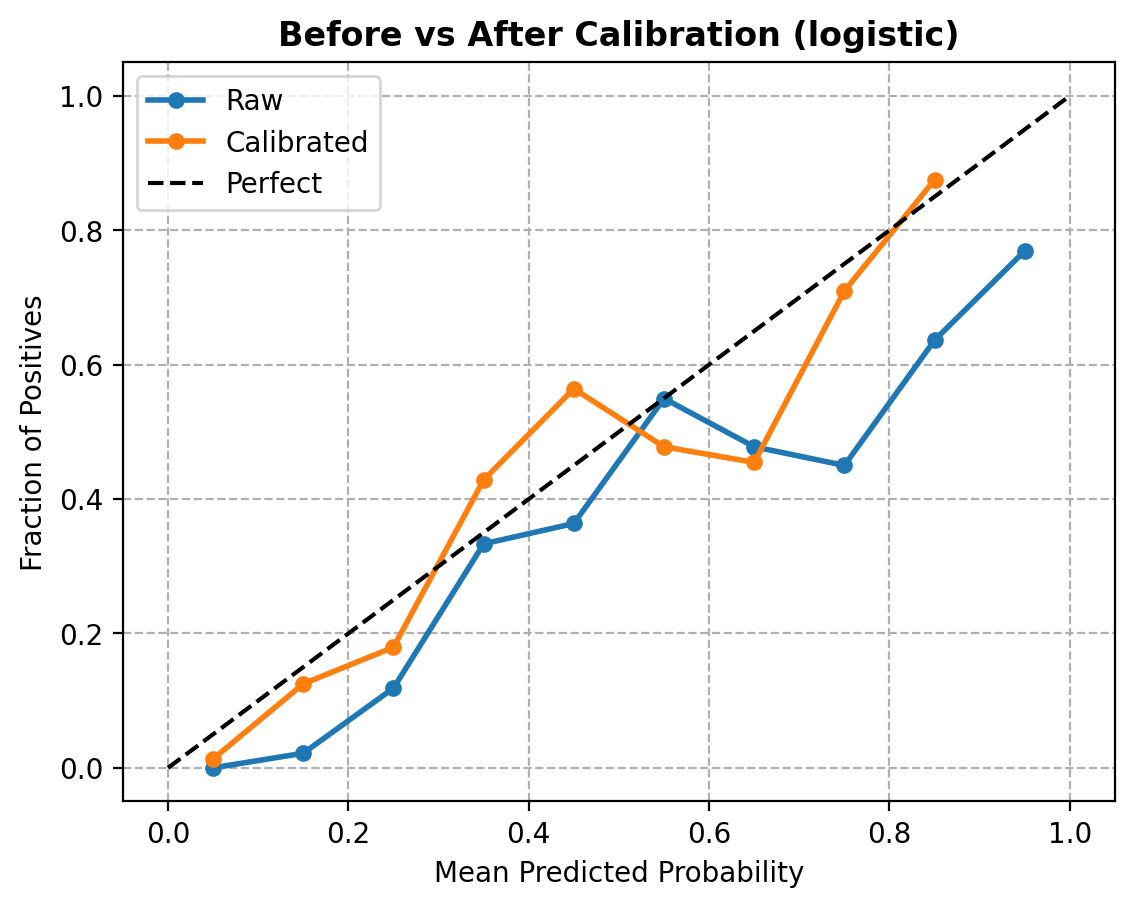

In [151]:
plot_before_after_calibration(
    df, 
    {'model': 'mistral_3', 'prompt': 'basic_prompt', 'n_articles': 10, 'k': 4},
    method='logistic', n_bins=10, test_size=0.5, random_state=42
)

Mistral is worse calibrated on the questions it's more certain about (predicted probability $\geq$ 70%), so it is more or less fixed by calibration

Gemini Flash

/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/andreypetukhov/Documents/Thesis/.venv/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


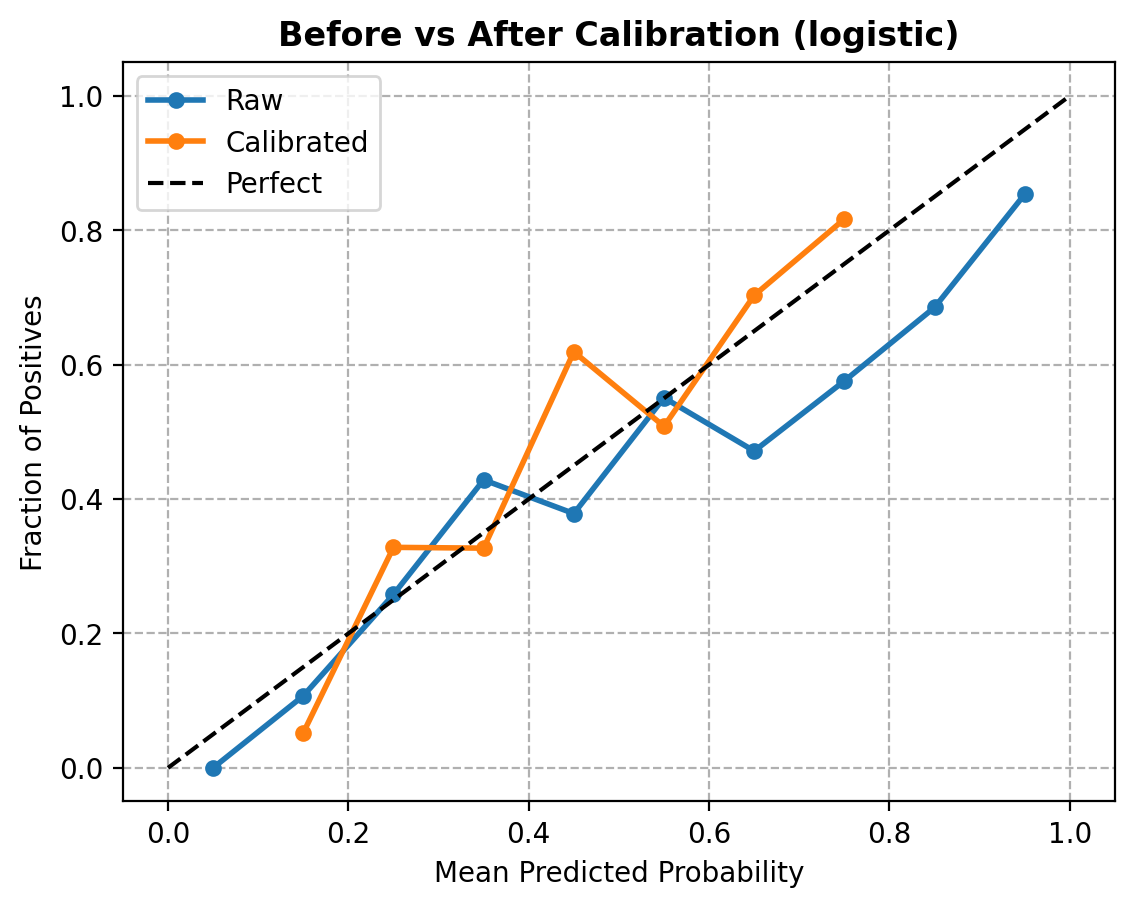

In [150]:
plot_before_after_calibration(
    df, 
    {'model': 'gemini_flash', 'prompt': 'basic_prompt', 'n_articles': 10, 'k': 4},
    method='logistic', n_bins=10, test_size=0.5, random_state=39
)

Calibration does not save Gemini Flash here, it is not well calibrated and cannot be calibrated to improve its performance on the calibration curve

## Various Aggregations of top models
Let's see how well the aggregated forecasts are

In [ ]:
def plot_aggregation_calibration(df, setups, methods=None, n_bins=5):
    if methods is None:
        methods = ['mean', 'median', 'trimmed_mean', 'geometric_mean', 'quadratic_mean']

    subsets = []
    event_sets = []
    for s in setups:
        sub = df[
            (df['model'] == s['model']) &
            (df['prompt_type'] == s['prompt_type']) &
            (df['n_articles'] == s['n_articles']) &
            (df['k'] == s['k'])
        ]
        subsets.append(sub)
        event_sets.append(set(sub['event_id']))
    common_events = set.intersection(*event_sets)
    if not common_events:
        raise ValueError("No common events found across the provided setups.")
    
    probs_list = []
    for sub in subsets:
        subc = sub[sub['event_id'].isin(common_events)].copy()
        subc.sort_values('event_id', inplace=True)
        probs_list.append(subc['probability_yes'].values)
    y_true = subc['true_label'].values
    arr = np.vstack(probs_list)
    
    def trimmed_mean_func(x):
        if x.shape[0] > 2:
            x_sorted = np.sort(x, axis=0)
            return np.mean(x_sorted[1:-1, :], axis=0)
        else:
            return np.mean(x, axis=0)
    
    agg_funcs = {
        'mean': lambda x: np.mean(x, axis=0),
        'median': lambda x: np.median(x, axis=0),
        'trimmed_mean':   trimmed_mean_func,
        'geometric_mean': lambda x: np.exp(np.mean(np.log(x + 1e-9), axis=0)),
        'quadratic_mean': lambda x: np.sqrt(np.mean(x**2, axis=0)),
    }

    bin_edges   = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    plt.figure(figsize=(8,6))
    for m in methods:
        if m not in agg_funcs:
            raise ValueError(f"Неизвестный метод агрегации: {m}")
        agg_preds = agg_funcs[m](arr)
        
        fractions = []
        for i in range(n_bins):
            mask = (agg_preds >= bin_edges[i]) & (agg_preds < bin_edges[i+1])
            fractions.append(np.mean(y_true[mask]) if mask.sum()>0 else np.nan)
        
        plt.plot(bin_centers, fractions, marker='.', label=m)
    
    plt.plot([0,1], [0,1], 'k--', label='Perfect')
    plt.title("Aggregated Calibration Curves", weight='bold')
    plt.xlabel("Mean Predicted Probability")
    plt.ylabel("Fraction of Positives")
    plt.ylim(-0.05, 1.05)
    plt.grid(alpha=0.5, linestyle='--')
    plt.legend()
    plt.show()

Aggregated calibration curves across the strongest setups must yield

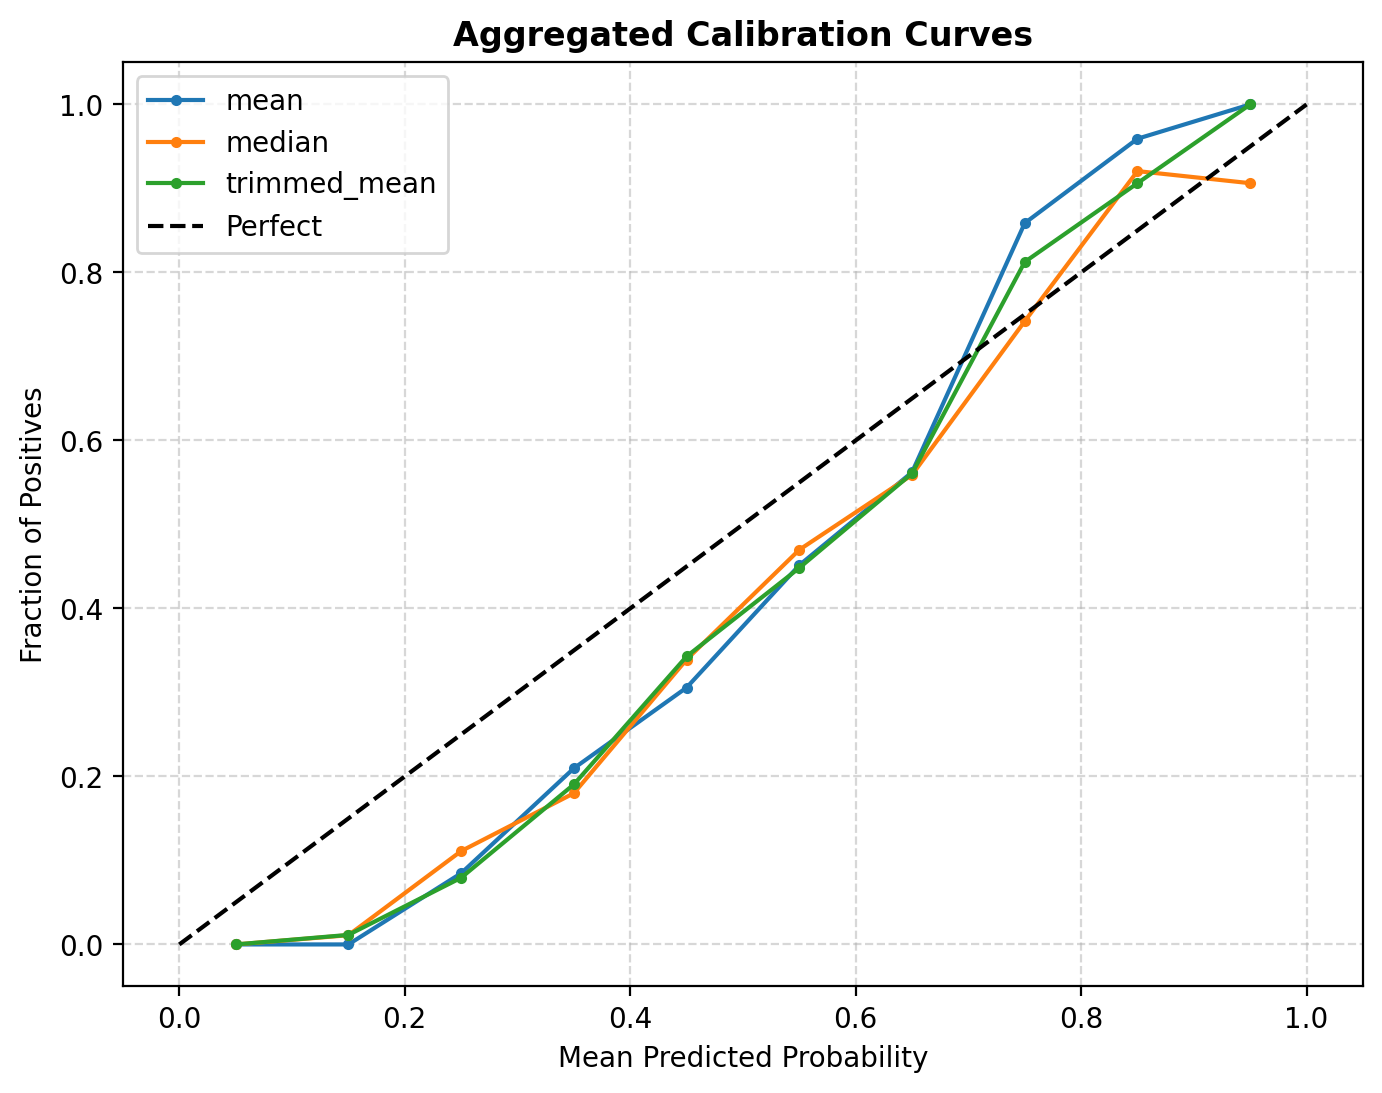

In [173]:
plot_aggregation_calibration(df, setups=[
    {'model': 'deepseek_r1', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
    {'model': 'deepseek_r1', 'prompt_type': 'two_stages', 'n_articles': 10, 'k': 3},
    {'model': 'deepseek_v3', 'prompt_type': 'champs_know', 'n_articles': 15, 'k': 4},
    {'model': 'deepseek_v3', 'prompt_type': 'champs_know', 'n_articles': 15, 'k': 3},
    {'model': 'mistral_3', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
    {'model': 'gemini_flash', 'prompt_type': 'basic_prompt', 'n_articles': 10, 'k': 4},
],
methods=["mean", "median", "trimmed_mean"], n_bins=10)

All the calibration methods yield very similar results, showing that the aggreagted forecasts are a little underconfident, so with calibration they can be significantly improved, which we have seen in the section above, where the aggregated stats showed the highest metrics

# Other

Auxilary charts not so relevant to the research

Let's see how the number of retrieved articles affects the quality of predictions

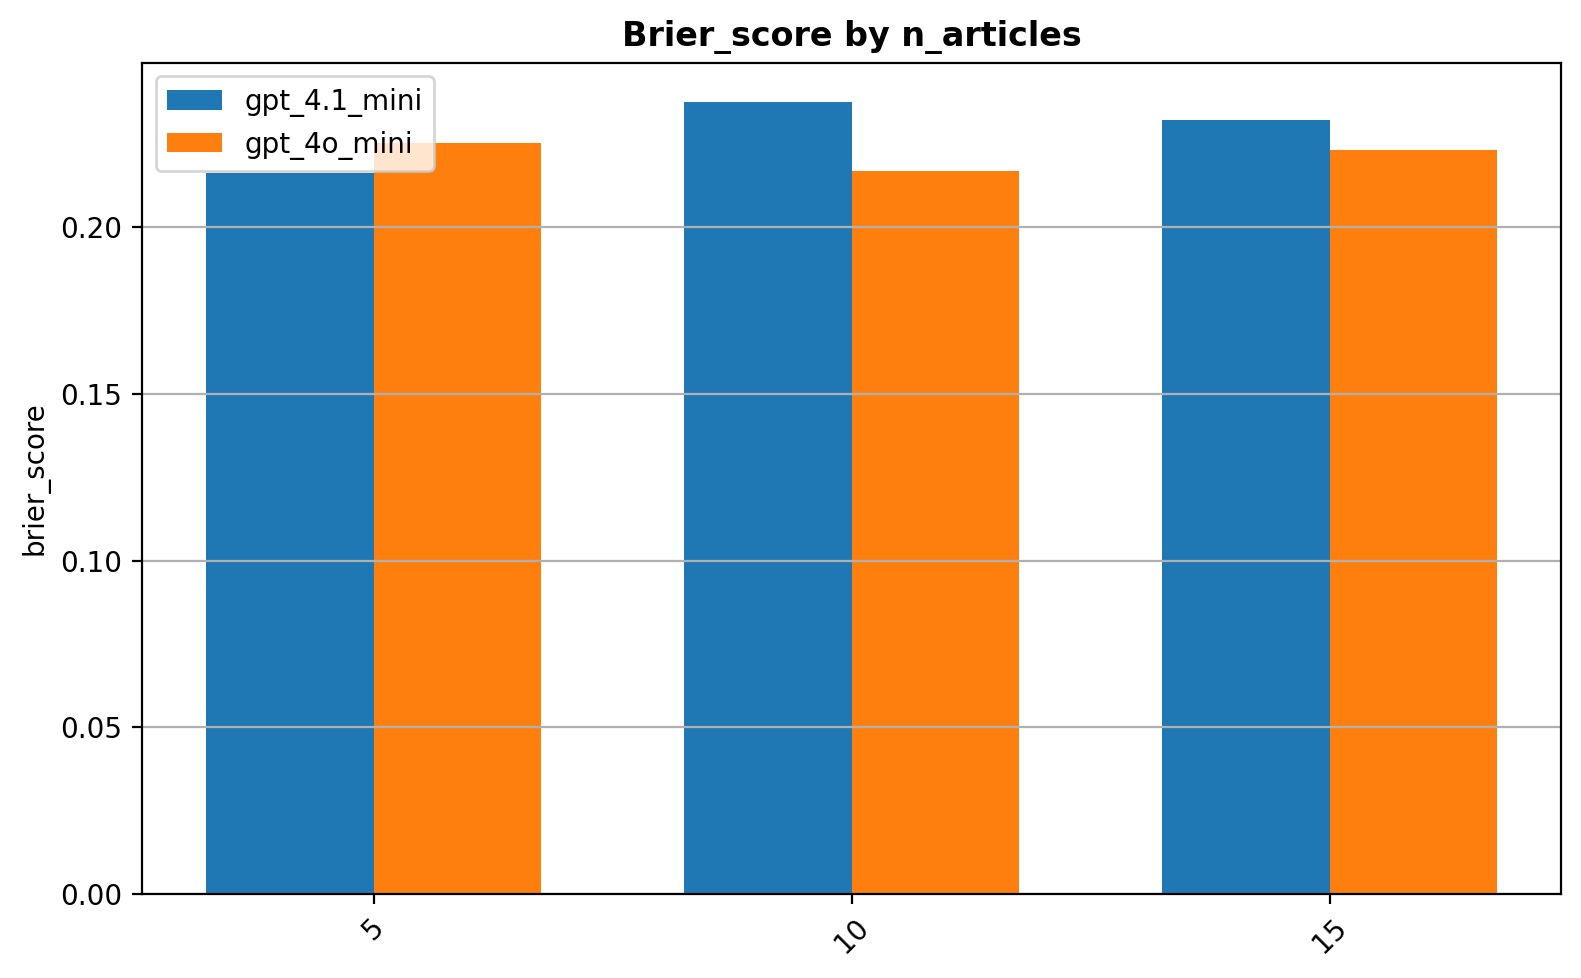

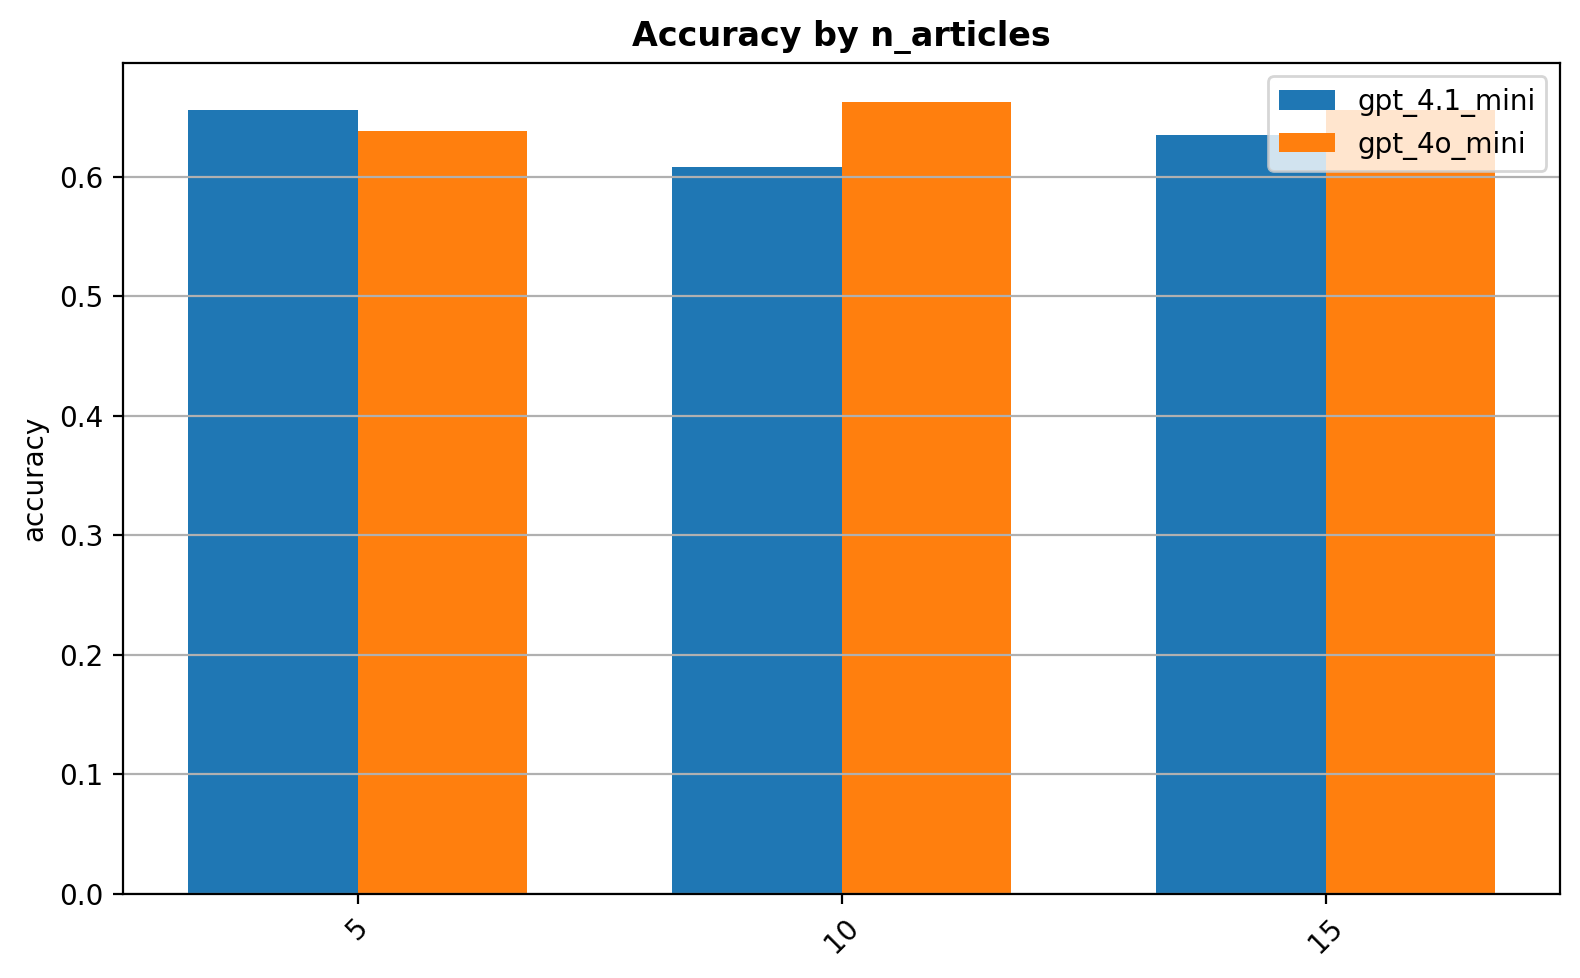

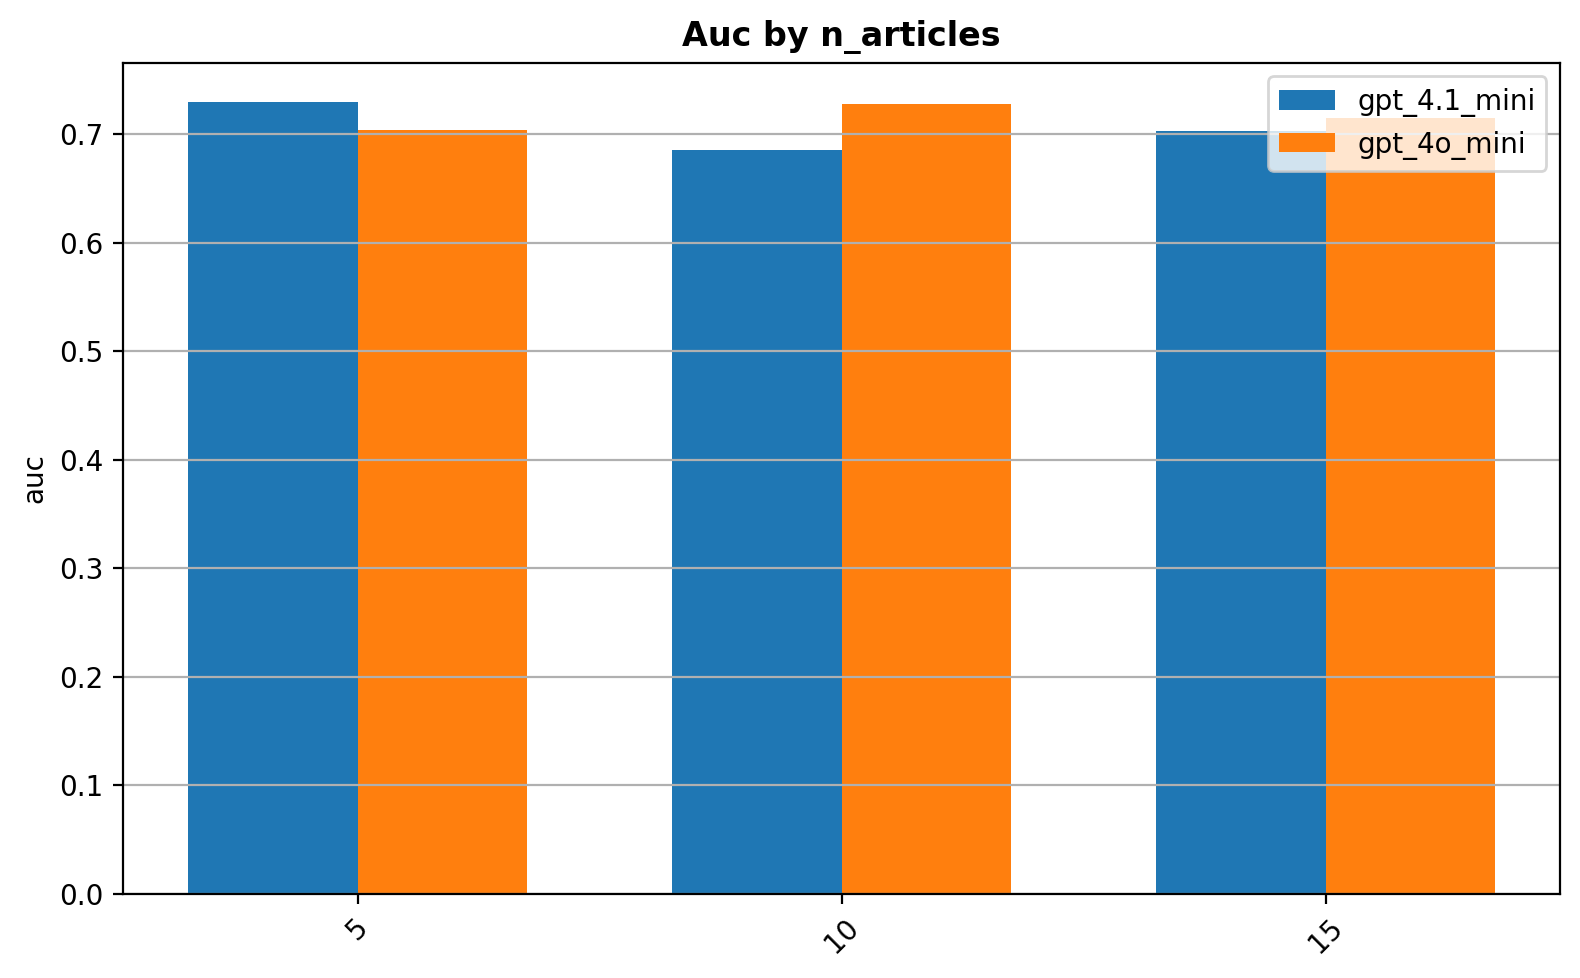

In [239]:
plot_models_by_factor(df, ['gpt_4.1_mini','gpt_4o_mini'], 'n_articles', [5,10,15])

There is no consistent pattern across the number of retrieved articels

Now let's have a look at how the prompt type affects our metrics

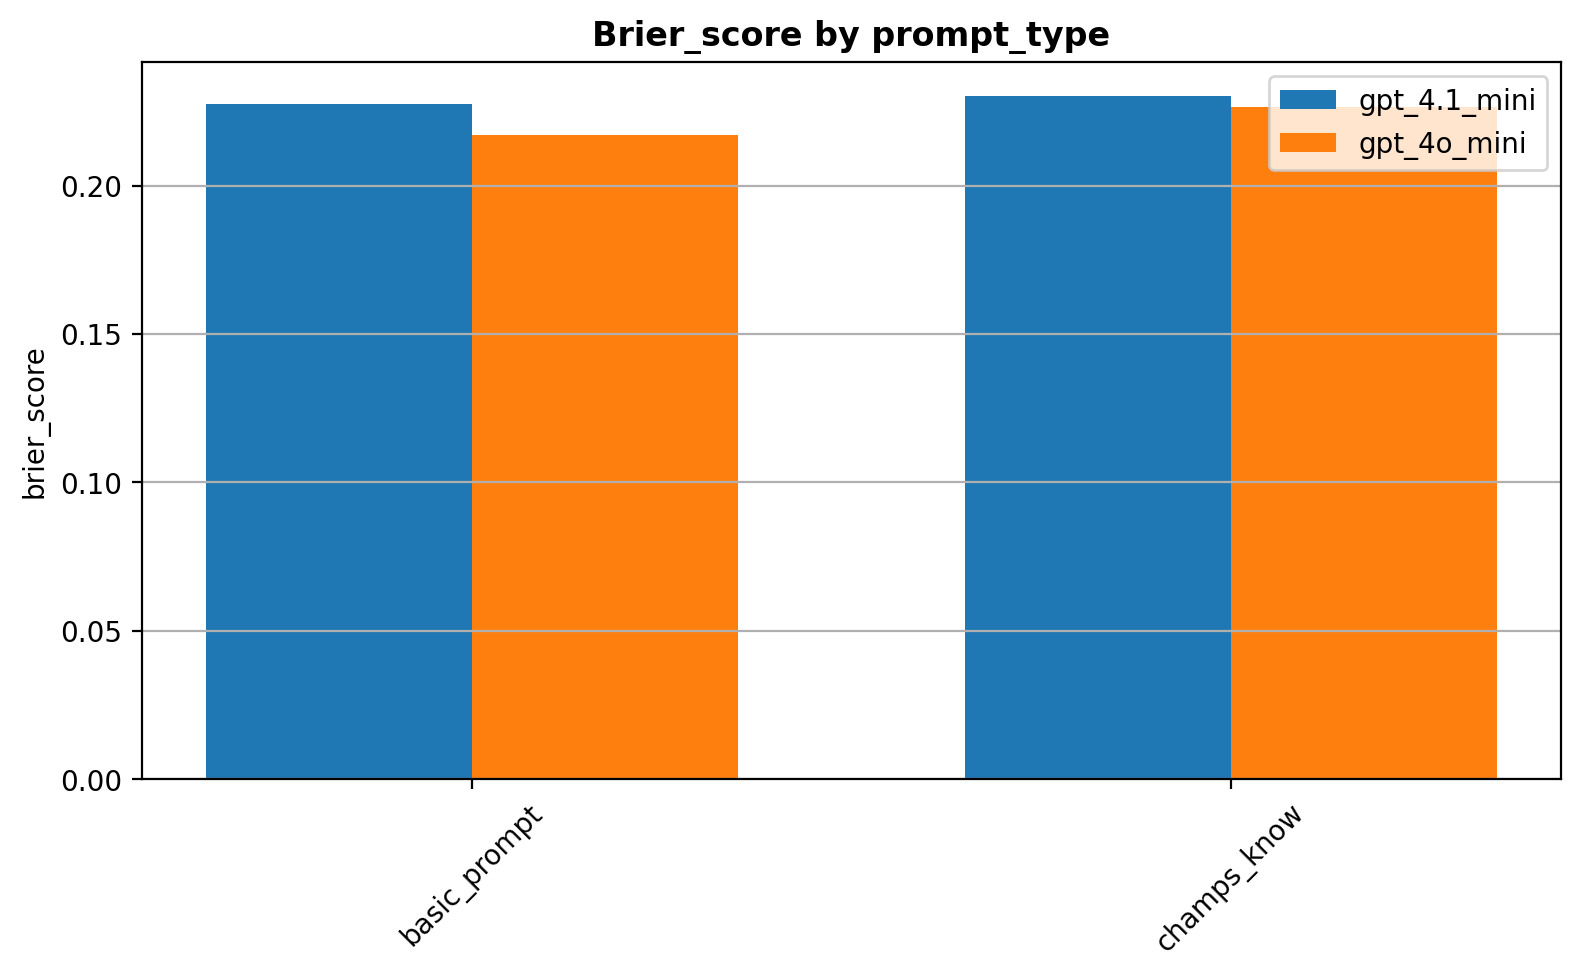

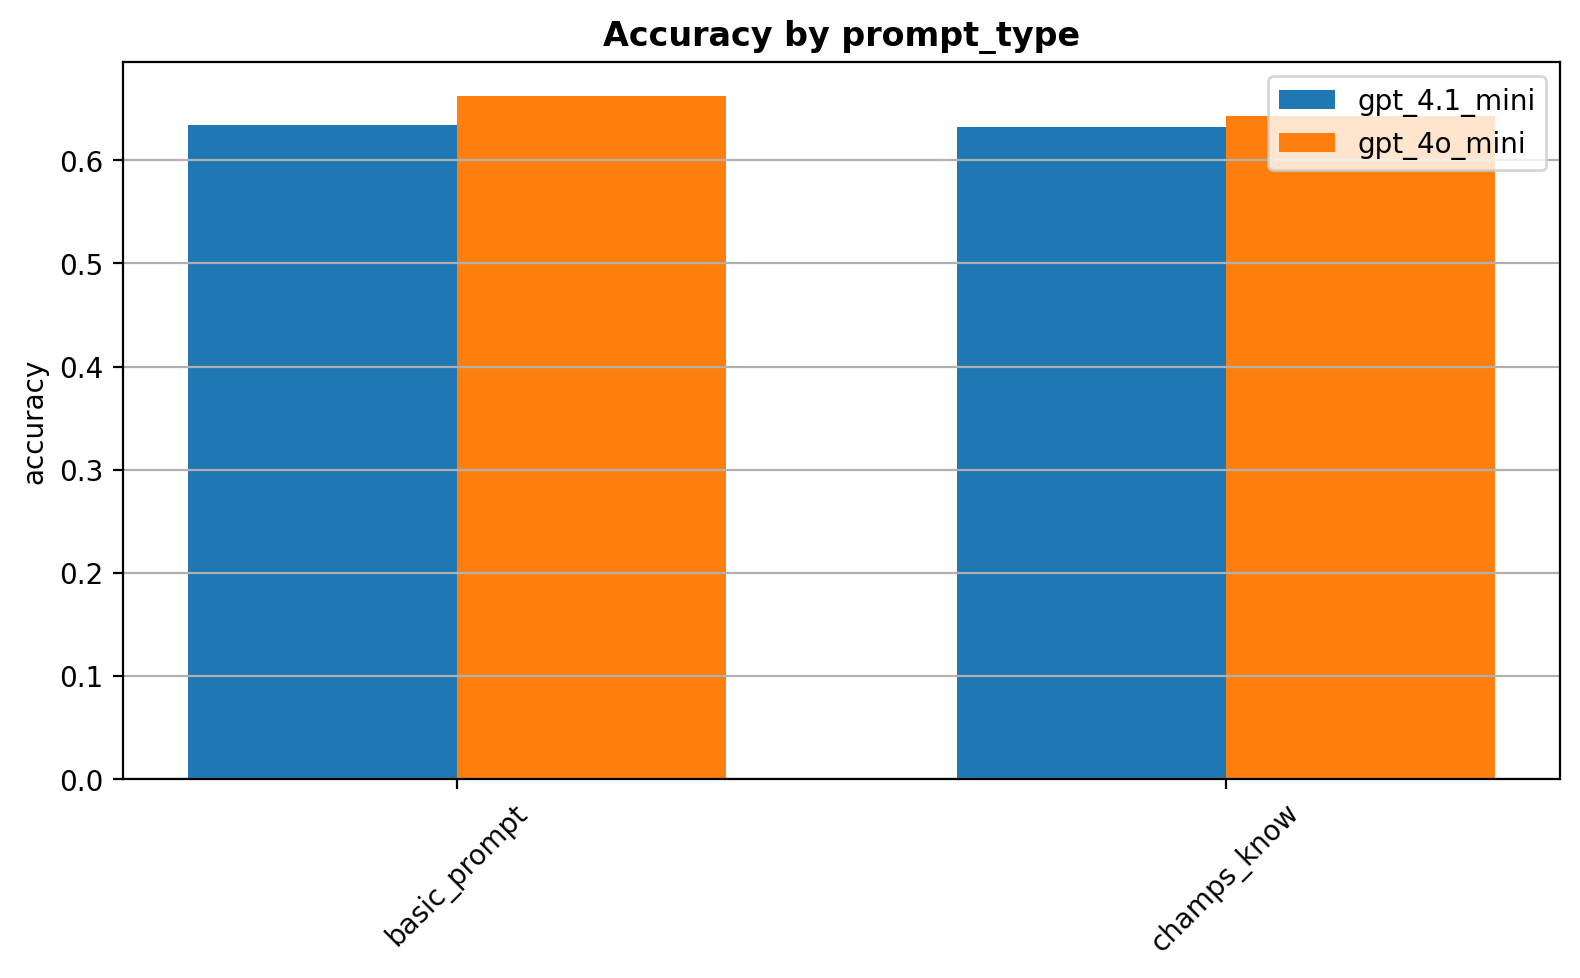

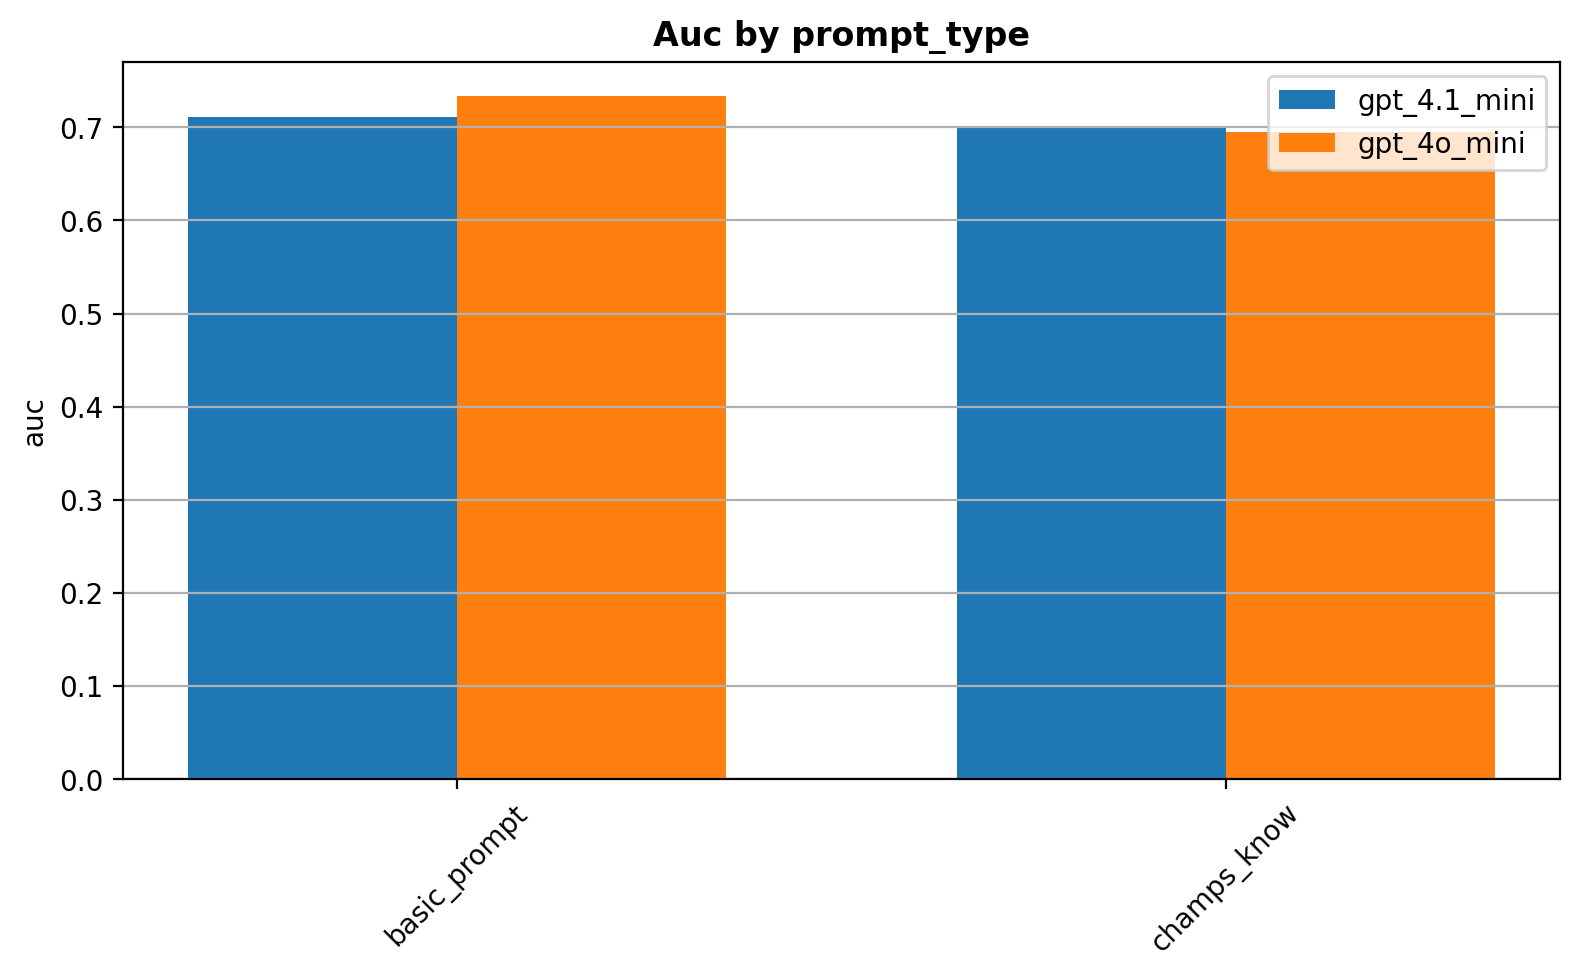

In [240]:
plot_models_by_factor(df, ['gpt_4.1_mini','gpt_4o_mini'], 'prompt_type', ["basic_prompt", "champs_know"])

Basic prompt and CHAMPS KNOW prompt yield almost the same results for the smaller models in my setups

In [272]:
class CategoryEncoder(BaseEstimator, TransformerMixin):
    """
    One-hot encode a 'categories' column containing stringified lists per event.
    """
    def __init__(self):
        self.mlb = MultiLabelBinarizer()

    def fit(self, X, y=None):
        lists = X.squeeze().apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
        self.mlb.fit(lists)
        return self

    def transform(self, X):
        lists = X.squeeze().apply(lambda s: ast.literal_eval(s) if isinstance(s, str) else s)
        arr = self.mlb.transform(lists)
        return pd.DataFrame(arr, columns=self.mlb.classes_, index=X.index)


def train_single_model_aggregator(df, model_name, prompt_type=None, test_size=0.2, random_state=42):
    mask = df['model'] == model_name
    if prompt_type is not None:
        mask &= df['prompt_type'] == prompt_type
    df_model = df[mask].copy()

    df_u = df_model.drop_duplicates('event_id').set_index('event_id')

    pivot = df_model.pivot(index='event_id', columns='k', values='probability_yes')
    pivot = pivot.rename(columns=lambda c: f"pred_k{c}")
    X = pivot.join(df_u[['num_articles_used']])

    cat_enc = CategoryEncoder()
    cat_feats = cat_enc.fit_transform(df_u[['categories']])
    X = X.join(cat_feats)
    y = df_u['true_label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    num_cols = [c for c in X.columns if c.startswith('pred_k') or c == 'num_articles_used']
    num_pipeline = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    preproc = ColumnTransformer([
        ('num', num_pipeline, num_cols)
    ], remainder='passthrough')

    pipe = Pipeline([
        ('prep', preproc),
        ('clf', LogisticRegression(max_iter=500, C=0.1))
    ])
    pipe.fit(X_train, y_train)

    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)

    metrics = {
        'brier': brier_score_loss(y_test, y_prob),
        'accuracy': accuracy_score(y_test, y_pred),
        'auc': roc_auc_score(y_test, y_prob)
    }
    preds_df = pd.DataFrame({'event_id': X_test.index, 'y_true': y_test,
                              'y_pred_prob': y_prob, 'y_pred': y_pred}).reset_index(drop=True)
    return preds_df, metrics


def train_multi_model_aggregator(df, model_list, test_size=0.2, random_state=42):
    df_u = df.drop_duplicates('event_id').set_index('event_id')
    frames = []
    for m in model_list:
        tmp = df[df['model'] == m]
        piv = tmp.pivot(index='event_id', columns='k', values='probability_yes')
        piv = piv.rename(columns=lambda c: f"{m}_pred_k{c}")
        frames.append(piv)
    X = pd.concat(frames, axis=1)

    if 'two_stages' in df_u['setup'].unique():
        X = X.join(df_u['base_rate'])

    cat_enc = CategoryEncoder()
    cat_feats = cat_enc.fit_transform(df_u[['categories']])
    X = X.join(cat_feats)
    y = df_u['true_label']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=random_state, stratify=y
    )

    num_cols = [c for c in X.columns if 'pred_k' in c or c in ('num_articles_used','base_rate')]
    num_pipe = Pipeline([
        ('impute', SimpleImputer(strategy='median')),
        ('scale', StandardScaler())
    ])
    preproc = ColumnTransformer([('num', num_pipe, num_cols)], remainder='passthrough')
    pipe = Pipeline([('prep', preproc), ('clf', LogisticRegression(max_iter=1000))])
    pipe.fit(X_train, y_train)
    y_prob = pipe.predict_proba(X_test)[:, 1]
    y_pred = pipe.predict(X_test)
    metrics = {'brier': brier_score_loss(y_test, y_prob),
               'accuracy': accuracy_score(y_test, y_pred),
               'auc': roc_auc_score(y_test, y_prob)}
    preds_df = pd.DataFrame({'event_id': X_test.index, 'y_true': y_test,
                              'y_pred_prob': y_prob, 'y_pred': y_pred}).reset_index(drop=True)
    return preds_df, metrics

preds_df, metrics = train_single_model_aggregator(df, "deepseek_r1", "basic_prompt", test_size=0.4, random_state=1)
metrics

{'brier': 0.2462357560281516, 'accuracy': 0.575, 'auc': 0.48705141012833325}

Trainable Logistic aggregation only worsens the initial model's forecasts and moves them towards random. This can be explained by the scarcity of training data. With larger datasets of predictions it would be possible to train the models on features like TF-IDF representations of the titles or descriptions, not only one-hot encoded categories and probabilities of the model through time.

# TODO

1) Карта с гео и предсказываемостью по геолокации
2) Таблица с качеством предсказаний в срезах по различным категориям (мб в виде heatmap?)